# Caltech-101 分类任务
- 数据集划分（7:1.5:1.5，train/val/test）
- 数据加载与增强
- 微调ResNet-18模型
- TensorBoard日志记录
- 测试与结果对比和保存

In [ ]:
import os, shutil, random
from pathlib import Path
from tqdm import tqdm

def split_caltech101(original_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, min_images=10, seed=42):
    random.seed(seed)

    original_dir = Path(original_dir)
    output_dir = Path(output_dir)

    # 划分
    for phase in ['train', 'val', 'test']:
        (output_dir / phase).mkdir(parents=True, exist_ok=True)

    for class_folder in tqdm(sorted(os.listdir(original_dir))):
        class_path = original_dir / class_folder
        if not class_path.is_dir():
            continue
        if class_folder.lower().startswith('background') or class_folder.lower().startswith('annotation'):
            continue

        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if len(images) < min_images:
            continue

        random.shuffle(images)

        n_total = len(images)
        n_train = int(n_total * train_ratio)
        n_val = int(n_total * val_ratio)
        n_test = n_total - n_train - n_val  

        split_data = {
            'train': images[:n_train],
            'val': images[n_train:n_train + n_val],
            'test': images[n_train + n_val:]
        }

        for phase, img_list in split_data.items():
            target_class_dir = output_dir / phase / class_folder
            target_class_dir.mkdir(parents=True, exist_ok=True)
            for img in img_list:
                shutil.copy(class_path / img, target_class_dir / img)

split_caltech101(
    original_dir='/kaggle/input/caltech-101/caltech-101',
    output_dir='/kaggle/input/caltech-101/caltech101_split_3way',
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    min_images=10,
    seed=42
)


In [ ]:
import os, shutil, random
from pathlib import Path
from tqdm import tqdm
import copy
import itertools
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

# 1.数据加载与增强
def get_dataloaders(data_dir='/kaggle/input/caltech101-split-3way/caltech101_split_3way', batch_size=64, num_workers=4):
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }

    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
    dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=(x=='train'), num_workers=num_workers) for x in ['train', 'val']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    class_names = image_datasets['train'].classes
    num_classes = len(class_names)

    return dataloaders, dataset_sizes, class_names, num_classes

# 2.训练模型
def train_model(model, dataloaders, dataset_sizes, device, num_epochs, lr_fc, lr_backbone, l2,
                optimizer_type='SGD', log_name='run', fine_tune=True):

    writer = SummaryWriter(log_dir=f'runs/{log_name}')
    criterion = nn.CrossEntropyLoss()

    # 设置优化器
    if fine_tune:
        params = [
            {'params': model.fc.parameters(), 'lr': lr_fc},
            {'params': [p for n, p in model.named_parameters() if 'fc' not in n], 'lr': lr_backbone}
        ]
    else:
        params = model.parameters()

    if optimizer_type == 'SGD':
        optimizer = optim.SGD(params, lr=lr_fc, momentum=0.9, weight_decay=l2)
    elif optimizer_type == 'AdamW':
        optimizer = optim.AdamW(params, lr=lr_fc, weight_decay=l2)
    else:
        raise ValueError("Unsupported optimizer type")

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss = 0.0
            running_corrects = 0

            loop = tqdm(dataloaders[phase], desc=f'{phase.capitalize()} [{epoch+1}/{num_epochs}]')
            for inputs, labels in loop:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            writer.add_scalar(f'{phase}_loss', epoch_loss, epoch)
            writer.add_scalar(f'{phase}_acc', epoch_acc, epoch)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print(f'\nBest val Acc: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model

# 3.超参数调优
if __name__ == '__main__':
    data_dir = '/kaggle/input/caltech101-split-3way/caltech101_split_3way'
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # 搜索空间
    lr_fc_list = [1e-2, 1e-3, 1e-4]
    lr_backbone_list = [1e-4, 1e-5]
    num_epochs_list = [10, 25]
    l2_list = [1e-4, 1e-5]
    batch_sizes = [16, 32]
    fine_tune_options = [True, False]
    optimizer_types = ['SGD', 'AdamW']

    trial = 0
    for batch_size, num_epochs, l2 in itertools.product(batch_sizes, num_epochs_list, l2_list):
        dataloaders, dataset_sizes, class_names, num_classes = get_dataloaders(data_dir, batch_size=batch_size)

        for fine_tune in fine_tune_options:
            lr_backbone_space = lr_backbone_list if fine_tune else [None]
            for lr_fc in lr_fc_list:
                for lr_backbone in lr_backbone_space:
                    for opt_type in (optimizer_types if fine_tune else ['SGD']):
                        trial += 1
                        log_name = f"trial_{trial}_bs{batch_size}_lrfc{lr_fc}_l2{l2}_ft{fine_tune}"
                        if fine_tune:
                            log_name += f"_lrbb{lr_backbone}_{opt_type}"
                        else:
                            log_name += "_scratch"

                        print(f"\n=== Running {log_name} ===")
                        # 初始化模型
                        if fine_tune:
                            model = models.resnet18(pretrained=True)
                        else:
                            model = models.resnet18(pretrained=False)

                        model.fc = nn.Linear(model.fc.in_features, num_classes)
                        model = model.to(device)

                        model = train_model(
                            model=model,
                            dataloaders=dataloaders,
                            dataset_sizes=dataset_sizes,
                            device=device,
                            num_epochs=num_epochs,
                            lr_fc=lr_fc,
                            lr_backbone=(lr_backbone if lr_backbone else lr_fc),
                            l2=l2,
                            optimizer_type=opt_type,
                            log_name=log_name,
                            fine_tune=fine_tune
                        )


2025-05-09 03:57:56.361634: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746763076.571937      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746763076.630714      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered



=== Running trial_1_bs16_lrfc0.01_l20.0001_ftTrue_lrbb0.0001_SGD ===


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 139MB/s] 



Epoch 1/10


Train [1/10]: 100%|██████████| 377/377 [00:17<00:00, 21.12it/s]


train Loss: 1.7962 Acc: 0.5868


Val [1/10]: 100%|██████████| 79/79 [00:03<00:00, 24.91it/s]


val Loss: 0.7143 Acc: 0.8288

Epoch 2/10


Train [2/10]: 100%|██████████| 377/377 [00:16<00:00, 23.53it/s]


train Loss: 0.8357 Acc: 0.7668


Val [2/10]: 100%|██████████| 79/79 [00:03<00:00, 23.29it/s]


val Loss: 0.3889 Acc: 0.8734

Epoch 3/10


Train [3/10]: 100%|██████████| 377/377 [00:16<00:00, 23.48it/s]


train Loss: 0.6734 Acc: 0.8123


Val [3/10]: 100%|██████████| 79/79 [00:02<00:00, 28.92it/s]


val Loss: 0.3741 Acc: 0.8901

Epoch 4/10


Train [4/10]: 100%|██████████| 377/377 [00:16<00:00, 23.12it/s]


train Loss: 0.6218 Acc: 0.8214


Val [4/10]: 100%|██████████| 79/79 [00:02<00:00, 29.01it/s]


val Loss: 0.3293 Acc: 0.8989

Epoch 5/10


Train [5/10]: 100%|██████████| 377/377 [00:16<00:00, 23.39it/s]


train Loss: 0.5459 Acc: 0.8462


Val [5/10]: 100%|██████████| 79/79 [00:02<00:00, 28.33it/s]


val Loss: 0.2788 Acc: 0.9108

Epoch 6/10


Train [6/10]: 100%|██████████| 377/377 [00:16<00:00, 22.96it/s]


train Loss: 0.5093 Acc: 0.8546


Val [6/10]: 100%|██████████| 79/79 [00:02<00:00, 28.41it/s]


val Loss: 0.3637 Acc: 0.9013

Epoch 7/10


Train [7/10]: 100%|██████████| 377/377 [00:16<00:00, 23.53it/s]


train Loss: 0.4973 Acc: 0.8618


Val [7/10]: 100%|██████████| 79/79 [00:02<00:00, 27.53it/s]


val Loss: 0.3221 Acc: 0.9076

Epoch 8/10


Train [8/10]: 100%|██████████| 377/377 [00:16<00:00, 23.13it/s]


train Loss: 0.4442 Acc: 0.8722


Val [8/10]: 100%|██████████| 79/79 [00:02<00:00, 27.32it/s]


val Loss: 0.2860 Acc: 0.9132

Epoch 9/10


Train [9/10]: 100%|██████████| 377/377 [00:16<00:00, 23.26it/s]


train Loss: 0.4409 Acc: 0.8716


Val [9/10]: 100%|██████████| 79/79 [00:02<00:00, 27.77it/s]


val Loss: 0.3248 Acc: 0.9061

Epoch 10/10


Train [10/10]: 100%|██████████| 377/377 [00:16<00:00, 23.36it/s]


train Loss: 0.4209 Acc: 0.8774


Val [10/10]: 100%|██████████| 79/79 [00:02<00:00, 28.56it/s]


val Loss: 0.3237 Acc: 0.9013

Best val Acc: 0.9132

=== Running trial_2_bs16_lrfc0.01_l20.0001_ftTrue_lrbb0.0001_AdamW ===

Epoch 1/10


Train [1/10]: 100%|██████████| 377/377 [00:16<00:00, 22.47it/s]


train Loss: 2.5881 Acc: 0.5304


Val [1/10]: 100%|██████████| 79/79 [00:02<00:00, 28.42it/s]


val Loss: 0.9324 Acc: 0.7484

Epoch 2/10


Train [2/10]: 100%|██████████| 377/377 [00:16<00:00, 22.98it/s]


train Loss: 1.4686 Acc: 0.6988


Val [2/10]: 100%|██████████| 79/79 [00:02<00:00, 28.34it/s]


val Loss: 0.6740 Acc: 0.8352

Epoch 3/10


Train [3/10]: 100%|██████████| 377/377 [00:16<00:00, 22.72it/s]


train Loss: 1.2814 Acc: 0.7323


Val [3/10]: 100%|██████████| 79/79 [00:02<00:00, 28.60it/s]


val Loss: 0.6109 Acc: 0.8511

Epoch 4/10


Train [4/10]: 100%|██████████| 377/377 [00:16<00:00, 23.03it/s]


train Loss: 1.0521 Acc: 0.7667


Val [4/10]: 100%|██████████| 79/79 [00:03<00:00, 24.57it/s]


val Loss: 0.6170 Acc: 0.8591

Epoch 5/10


Train [5/10]: 100%|██████████| 377/377 [00:16<00:00, 22.87it/s]


train Loss: 1.1802 Acc: 0.7660


Val [5/10]: 100%|██████████| 79/79 [00:02<00:00, 28.12it/s]


val Loss: 0.7101 Acc: 0.8551

Epoch 6/10


Train [6/10]: 100%|██████████| 377/377 [00:16<00:00, 22.68it/s]


train Loss: 1.2020 Acc: 0.7712


Val [6/10]: 100%|██████████| 79/79 [00:02<00:00, 28.64it/s]


val Loss: 0.5307 Acc: 0.8623

Epoch 7/10


Train [7/10]: 100%|██████████| 377/377 [00:16<00:00, 22.99it/s]


train Loss: 1.2142 Acc: 0.7733


Val [7/10]: 100%|██████████| 79/79 [00:02<00:00, 28.39it/s]


val Loss: 0.5483 Acc: 0.8646

Epoch 8/10


Train [8/10]: 100%|██████████| 377/377 [00:16<00:00, 22.58it/s]


train Loss: 0.8835 Acc: 0.8052


Val [8/10]: 100%|██████████| 79/79 [00:02<00:00, 28.12it/s]


val Loss: 0.5855 Acc: 0.8742

Epoch 9/10


Train [9/10]: 100%|██████████| 377/377 [00:16<00:00, 23.02it/s]


train Loss: 1.1933 Acc: 0.7843


Val [9/10]: 100%|██████████| 79/79 [00:03<00:00, 23.73it/s]


val Loss: 0.8169 Acc: 0.8248

Epoch 10/10


Train [10/10]: 100%|██████████| 377/377 [00:16<00:00, 22.93it/s]


train Loss: 1.2625 Acc: 0.7773


Val [10/10]: 100%|██████████| 79/79 [00:02<00:00, 28.37it/s]


val Loss: 0.6081 Acc: 0.8615

Best val Acc: 0.8742

=== Running trial_3_bs16_lrfc0.01_l20.0001_ftTrue_lrbb1e-05_SGD ===

Epoch 1/10


Train [1/10]: 100%|██████████| 377/377 [00:16<00:00, 22.94it/s]


train Loss: 1.8181 Acc: 0.5818


Val [1/10]: 100%|██████████| 79/79 [00:02<00:00, 28.24it/s]


val Loss: 0.7317 Acc: 0.7882

Epoch 2/10


Train [2/10]: 100%|██████████| 377/377 [00:16<00:00, 23.46it/s]


train Loss: 0.9401 Acc: 0.7539


Val [2/10]: 100%|██████████| 79/79 [00:02<00:00, 28.08it/s]


val Loss: 0.5010 Acc: 0.8543

Epoch 3/10


Train [3/10]: 100%|██████████| 377/377 [00:16<00:00, 23.21it/s]


train Loss: 0.8002 Acc: 0.7849


Val [3/10]: 100%|██████████| 79/79 [00:02<00:00, 28.07it/s]


val Loss: 0.4487 Acc: 0.8662

Epoch 4/10


Train [4/10]: 100%|██████████| 377/377 [00:16<00:00, 23.45it/s]


train Loss: 0.6872 Acc: 0.8120


Val [4/10]: 100%|██████████| 79/79 [00:02<00:00, 26.87it/s]


val Loss: 0.4020 Acc: 0.8774

Epoch 5/10


Train [5/10]: 100%|██████████| 377/377 [00:16<00:00, 23.06it/s]


train Loss: 0.6683 Acc: 0.8126


Val [5/10]: 100%|██████████| 79/79 [00:02<00:00, 28.96it/s]


val Loss: 0.3524 Acc: 0.8917

Epoch 6/10


Train [6/10]: 100%|██████████| 377/377 [00:16<00:00, 23.18it/s]


train Loss: 0.6203 Acc: 0.8261


Val [6/10]: 100%|██████████| 79/79 [00:02<00:00, 28.68it/s]


val Loss: 0.3847 Acc: 0.8901

Epoch 7/10


Train [7/10]: 100%|██████████| 377/377 [00:16<00:00, 23.47it/s]


train Loss: 0.5970 Acc: 0.8306


Val [7/10]: 100%|██████████| 79/79 [00:02<00:00, 28.02it/s]


val Loss: 0.4232 Acc: 0.8814

Epoch 8/10


Train [8/10]: 100%|██████████| 377/377 [00:16<00:00, 23.08it/s]


train Loss: 0.5578 Acc: 0.8467


Val [8/10]: 100%|██████████| 79/79 [00:02<00:00, 28.69it/s]


val Loss: 0.3502 Acc: 0.9053

Epoch 9/10


Train [9/10]: 100%|██████████| 377/377 [00:16<00:00, 23.45it/s]


train Loss: 0.5347 Acc: 0.8463


Val [9/10]: 100%|██████████| 79/79 [00:02<00:00, 28.84it/s]


val Loss: 0.3994 Acc: 0.8893

Epoch 10/10


Train [10/10]: 100%|██████████| 377/377 [00:16<00:00, 23.09it/s]


train Loss: 0.5474 Acc: 0.8487


Val [10/10]: 100%|██████████| 79/79 [00:02<00:00, 29.03it/s]


val Loss: 0.4877 Acc: 0.8694

Best val Acc: 0.9053

=== Running trial_4_bs16_lrfc0.01_l20.0001_ftTrue_lrbb1e-05_AdamW ===

Epoch 1/10


Train [1/10]: 100%|██████████| 377/377 [00:16<00:00, 23.19it/s]


train Loss: 2.7684 Acc: 0.5614


Val [1/10]: 100%|██████████| 79/79 [00:03<00:00, 25.13it/s]


val Loss: 0.9638 Acc: 0.8057

Epoch 2/10


Train [2/10]: 100%|██████████| 377/377 [00:16<00:00, 23.39it/s]


train Loss: 1.6343 Acc: 0.7154


Val [2/10]: 100%|██████████| 79/79 [00:02<00:00, 28.71it/s]


val Loss: 1.3831 Acc: 0.7930

Epoch 3/10


Train [3/10]: 100%|██████████| 377/377 [00:16<00:00, 23.05it/s]


train Loss: 1.4533 Acc: 0.7549


Val [3/10]: 100%|██████████| 79/79 [00:02<00:00, 28.42it/s]


val Loss: 0.9510 Acc: 0.8360

Epoch 4/10


Train [4/10]: 100%|██████████| 377/377 [00:16<00:00, 23.27it/s]


train Loss: 1.3299 Acc: 0.7823


Val [4/10]: 100%|██████████| 79/79 [00:02<00:00, 28.24it/s]


val Loss: 0.8870 Acc: 0.8631

Epoch 5/10


Train [5/10]: 100%|██████████| 377/377 [00:16<00:00, 22.86it/s]


train Loss: 1.0970 Acc: 0.7982


Val [5/10]: 100%|██████████| 79/79 [00:02<00:00, 29.09it/s]


val Loss: 0.7434 Acc: 0.8949

Epoch 6/10


Train [6/10]: 100%|██████████| 377/377 [00:16<00:00, 23.13it/s]


train Loss: 1.0322 Acc: 0.8093


Val [6/10]: 100%|██████████| 79/79 [00:03<00:00, 25.15it/s]


val Loss: 0.6627 Acc: 0.8854

Epoch 7/10


Train [7/10]: 100%|██████████| 377/377 [00:16<00:00, 22.83it/s]


train Loss: 1.0013 Acc: 0.8166


Val [7/10]: 100%|██████████| 79/79 [00:02<00:00, 28.54it/s]


val Loss: 0.6690 Acc: 0.8846

Epoch 8/10


Train [8/10]: 100%|██████████| 377/377 [00:16<00:00, 22.95it/s]


train Loss: 1.0195 Acc: 0.8233


Val [8/10]: 100%|██████████| 79/79 [00:02<00:00, 28.71it/s]


val Loss: 0.8119 Acc: 0.8822

Epoch 9/10


Train [9/10]: 100%|██████████| 377/377 [00:16<00:00, 23.10it/s]


train Loss: 0.9235 Acc: 0.8324


Val [9/10]: 100%|██████████| 79/79 [00:02<00:00, 28.42it/s]


val Loss: 0.7709 Acc: 0.8885

Epoch 10/10


Train [10/10]: 100%|██████████| 377/377 [00:16<00:00, 22.62it/s]


train Loss: 0.8661 Acc: 0.8422


Val [10/10]: 100%|██████████| 79/79 [00:02<00:00, 28.52it/s]


val Loss: 0.5410 Acc: 0.8989

Best val Acc: 0.8989

=== Running trial_5_bs16_lrfc0.001_l20.0001_ftTrue_lrbb0.0001_SGD ===

Epoch 1/10


Train [1/10]: 100%|██████████| 377/377 [00:16<00:00, 23.28it/s]


train Loss: 2.9240 Acc: 0.3953


Val [1/10]: 100%|██████████| 79/79 [00:02<00:00, 28.24it/s]


val Loss: 1.6801 Acc: 0.6346

Epoch 2/10


Train [2/10]: 100%|██████████| 377/377 [00:16<00:00, 22.85it/s]


train Loss: 1.7491 Acc: 0.6367


Val [2/10]: 100%|██████████| 79/79 [00:02<00:00, 28.10it/s]


val Loss: 0.9274 Acc: 0.7731

Epoch 3/10


Train [3/10]: 100%|██████████| 377/377 [00:16<00:00, 22.97it/s]


train Loss: 1.2427 Acc: 0.7381


Val [3/10]: 100%|██████████| 79/79 [00:02<00:00, 27.98it/s]


val Loss: 0.6356 Acc: 0.8503

Epoch 4/10


Train [4/10]: 100%|██████████| 377/377 [00:16<00:00, 23.41it/s]


train Loss: 0.9989 Acc: 0.7805


Val [4/10]: 100%|██████████| 79/79 [00:02<00:00, 28.58it/s]


val Loss: 0.5087 Acc: 0.8710

Epoch 5/10


Train [5/10]: 100%|██████████| 377/377 [00:16<00:00, 23.13it/s]


train Loss: 0.8339 Acc: 0.8113


Val [5/10]: 100%|██████████| 79/79 [00:02<00:00, 27.89it/s]


val Loss: 0.4240 Acc: 0.8909

Epoch 6/10


Train [6/10]: 100%|██████████| 377/377 [00:16<00:00, 23.44it/s]


train Loss: 0.7645 Acc: 0.8241


Val [6/10]: 100%|██████████| 79/79 [00:02<00:00, 28.48it/s]


val Loss: 0.3645 Acc: 0.9068

Epoch 7/10


Train [7/10]: 100%|██████████| 377/377 [00:16<00:00, 23.15it/s]


train Loss: 0.6807 Acc: 0.8369


Val [7/10]: 100%|██████████| 79/79 [00:02<00:00, 28.07it/s]


val Loss: 0.3360 Acc: 0.9140

Epoch 8/10


Train [8/10]: 100%|██████████| 377/377 [00:15<00:00, 23.57it/s]


train Loss: 0.6308 Acc: 0.8467


Val [8/10]: 100%|██████████| 79/79 [00:03<00:00, 23.82it/s]


val Loss: 0.3108 Acc: 0.9188

Epoch 9/10


Train [9/10]: 100%|██████████| 377/377 [00:16<00:00, 23.45it/s]


train Loss: 0.5970 Acc: 0.8563


Val [9/10]: 100%|██████████| 79/79 [00:02<00:00, 28.16it/s]


val Loss: 0.2911 Acc: 0.9252

Epoch 10/10


Train [10/10]: 100%|██████████| 377/377 [00:16<00:00, 23.07it/s]


train Loss: 0.5645 Acc: 0.8616


Val [10/10]: 100%|██████████| 79/79 [00:02<00:00, 29.56it/s]


val Loss: 0.2681 Acc: 0.9283

Best val Acc: 0.9283

=== Running trial_6_bs16_lrfc0.001_l20.0001_ftTrue_lrbb0.0001_AdamW ===

Epoch 1/10


Train [1/10]: 100%|██████████| 377/377 [00:15<00:00, 23.59it/s]


train Loss: 1.7655 Acc: 0.5992


Val [1/10]: 100%|██████████| 79/79 [00:02<00:00, 29.85it/s]


val Loss: 0.4654 Acc: 0.8662

Epoch 2/10


Train [2/10]: 100%|██████████| 377/377 [00:16<00:00, 23.34it/s]


train Loss: 0.8304 Acc: 0.7740


Val [2/10]: 100%|██████████| 79/79 [00:02<00:00, 28.91it/s]


val Loss: 0.3674 Acc: 0.8846

Epoch 3/10


Train [3/10]: 100%|██████████| 377/377 [00:16<00:00, 23.50it/s]


train Loss: 0.6364 Acc: 0.8253


Val [3/10]: 100%|██████████| 79/79 [00:02<00:00, 30.05it/s]


val Loss: 0.3408 Acc: 0.9029

Epoch 4/10


Train [4/10]: 100%|██████████| 377/377 [00:16<00:00, 23.30it/s]


train Loss: 0.5797 Acc: 0.8443


Val [4/10]: 100%|██████████| 79/79 [00:02<00:00, 29.96it/s]


val Loss: 0.3263 Acc: 0.8973

Epoch 5/10


Train [5/10]: 100%|██████████| 377/377 [00:15<00:00, 23.60it/s]


train Loss: 0.5438 Acc: 0.8477


Val [5/10]: 100%|██████████| 79/79 [00:02<00:00, 26.56it/s]


val Loss: 0.3669 Acc: 0.8917

Epoch 6/10


Train [6/10]: 100%|██████████| 377/377 [00:15<00:00, 23.64it/s]


train Loss: 0.5288 Acc: 0.8526


Val [6/10]: 100%|██████████| 79/79 [00:02<00:00, 29.41it/s]


val Loss: 0.3869 Acc: 0.8877

Epoch 7/10


Train [7/10]: 100%|██████████| 377/377 [00:16<00:00, 23.31it/s]


train Loss: 0.4713 Acc: 0.8706


Val [7/10]: 100%|██████████| 79/79 [00:02<00:00, 29.58it/s]


val Loss: 0.3813 Acc: 0.8909

Epoch 8/10


Train [8/10]: 100%|██████████| 377/377 [00:16<00:00, 23.52it/s]


train Loss: 0.4660 Acc: 0.8657


Val [8/10]: 100%|██████████| 79/79 [00:02<00:00, 28.64it/s]


val Loss: 0.3447 Acc: 0.8949

Epoch 9/10


Train [9/10]: 100%|██████████| 377/377 [00:16<00:00, 23.12it/s]


train Loss: 0.4680 Acc: 0.8682


Val [9/10]: 100%|██████████| 79/79 [00:02<00:00, 29.06it/s]


val Loss: 0.3685 Acc: 0.8941

Epoch 10/10


Train [10/10]: 100%|██████████| 377/377 [00:16<00:00, 23.42it/s]


train Loss: 0.4257 Acc: 0.8800


Val [10/10]: 100%|██████████| 79/79 [00:02<00:00, 27.38it/s]


val Loss: 0.3832 Acc: 0.8909

Best val Acc: 0.9029

=== Running trial_7_bs16_lrfc0.001_l20.0001_ftTrue_lrbb1e-05_SGD ===

Epoch 1/10


Train [1/10]: 100%|██████████| 377/377 [00:15<00:00, 23.58it/s]


train Loss: 3.0150 Acc: 0.3724


Val [1/10]: 100%|██████████| 79/79 [00:02<00:00, 29.34it/s]


val Loss: 1.8327 Acc: 0.5971

Epoch 2/10


Train [2/10]: 100%|██████████| 377/377 [00:16<00:00, 23.47it/s]


train Loss: 1.9332 Acc: 0.6040


Val [2/10]: 100%|██████████| 79/79 [00:02<00:00, 28.52it/s]


val Loss: 1.1431 Acc: 0.7580

Epoch 3/10


Train [3/10]: 100%|██████████| 377/377 [00:15<00:00, 23.98it/s]


train Loss: 1.4417 Acc: 0.7059


Val [3/10]: 100%|██████████| 79/79 [00:02<00:00, 29.73it/s]


val Loss: 0.8203 Acc: 0.8097

Epoch 4/10


Train [4/10]: 100%|██████████| 377/377 [00:15<00:00, 23.60it/s]


train Loss: 1.2270 Acc: 0.7378


Val [4/10]: 100%|██████████| 79/79 [00:02<00:00, 28.47it/s]


val Loss: 0.6691 Acc: 0.8455

Epoch 5/10


Train [5/10]: 100%|██████████| 377/377 [00:15<00:00, 23.70it/s]


train Loss: 1.0629 Acc: 0.7692


Val [5/10]: 100%|██████████| 79/79 [00:02<00:00, 28.60it/s]


val Loss: 0.5637 Acc: 0.8543

Epoch 6/10


Train [6/10]: 100%|██████████| 377/377 [00:15<00:00, 23.64it/s]


train Loss: 0.9308 Acc: 0.7985


Val [6/10]: 100%|██████████| 79/79 [00:02<00:00, 29.45it/s]


val Loss: 0.4894 Acc: 0.8774

Epoch 7/10


Train [7/10]: 100%|██████████| 377/377 [00:15<00:00, 23.81it/s]


train Loss: 0.8537 Acc: 0.8131


Val [7/10]: 100%|██████████| 79/79 [00:02<00:00, 26.39it/s]


val Loss: 0.4380 Acc: 0.8838

Epoch 8/10


Train [8/10]: 100%|██████████| 377/377 [00:16<00:00, 23.40it/s]


train Loss: 0.7780 Acc: 0.8246


Val [8/10]: 100%|██████████| 79/79 [00:02<00:00, 28.49it/s]


val Loss: 0.4193 Acc: 0.8758

Epoch 9/10


Train [9/10]: 100%|██████████| 377/377 [00:16<00:00, 23.30it/s]


train Loss: 0.7544 Acc: 0.8241


Val [9/10]: 100%|██████████| 79/79 [00:02<00:00, 29.29it/s]


val Loss: 0.3892 Acc: 0.8933

Epoch 10/10


Train [10/10]: 100%|██████████| 377/377 [00:15<00:00, 23.67it/s]


train Loss: 0.6864 Acc: 0.8370


Val [10/10]: 100%|██████████| 79/79 [00:02<00:00, 29.36it/s]


val Loss: 0.3783 Acc: 0.8869

Best val Acc: 0.8933

=== Running trial_8_bs16_lrfc0.001_l20.0001_ftTrue_lrbb1e-05_AdamW ===

Epoch 1/10


Train [1/10]: 100%|██████████| 377/377 [00:16<00:00, 23.11it/s]


train Loss: 2.1058 Acc: 0.5420


Val [1/10]: 100%|██████████| 79/79 [00:02<00:00, 28.75it/s]


val Loss: 0.6028 Acc: 0.8503

Epoch 2/10


Train [2/10]: 100%|██████████| 377/377 [00:16<00:00, 23.40it/s]


train Loss: 0.8540 Acc: 0.7750


Val [2/10]: 100%|██████████| 79/79 [00:02<00:00, 28.88it/s]


val Loss: 0.3671 Acc: 0.8981

Epoch 3/10


Train [3/10]: 100%|██████████| 377/377 [00:16<00:00, 23.00it/s]


train Loss: 0.6323 Acc: 0.8309


Val [3/10]: 100%|██████████| 79/79 [00:02<00:00, 28.88it/s]


val Loss: 0.3461 Acc: 0.8997

Epoch 4/10


Train [4/10]: 100%|██████████| 377/377 [00:16<00:00, 23.28it/s]


train Loss: 0.5466 Acc: 0.8553


Val [4/10]: 100%|██████████| 79/79 [00:03<00:00, 23.73it/s]


val Loss: 0.2804 Acc: 0.9156

Epoch 5/10


Train [5/10]: 100%|██████████| 377/377 [00:16<00:00, 23.26it/s]


train Loss: 0.5016 Acc: 0.8598


Val [5/10]: 100%|██████████| 79/79 [00:02<00:00, 28.25it/s]


val Loss: 0.2618 Acc: 0.9275

Epoch 6/10


Train [6/10]: 100%|██████████| 377/377 [00:16<00:00, 22.67it/s]


train Loss: 0.4470 Acc: 0.8704


Val [6/10]: 100%|██████████| 79/79 [00:02<00:00, 28.72it/s]


val Loss: 0.2713 Acc: 0.9220

Epoch 7/10


Train [7/10]: 100%|██████████| 377/377 [00:16<00:00, 22.87it/s]


train Loss: 0.4098 Acc: 0.8785


Val [7/10]: 100%|██████████| 79/79 [00:02<00:00, 28.24it/s]


val Loss: 0.2632 Acc: 0.9188

Epoch 8/10


Train [8/10]: 100%|██████████| 377/377 [00:16<00:00, 22.66it/s]


train Loss: 0.3973 Acc: 0.8833


Val [8/10]: 100%|██████████| 79/79 [00:02<00:00, 27.92it/s]


val Loss: 0.2499 Acc: 0.9236

Epoch 9/10


Train [9/10]: 100%|██████████| 377/377 [00:16<00:00, 23.06it/s]


train Loss: 0.3731 Acc: 0.8925


Val [9/10]: 100%|██████████| 79/79 [00:03<00:00, 23.50it/s]


val Loss: 0.2504 Acc: 0.9236

Epoch 10/10


Train [10/10]: 100%|██████████| 377/377 [00:16<00:00, 23.01it/s]


train Loss: 0.3578 Acc: 0.8971


Val [10/10]: 100%|██████████| 79/79 [00:02<00:00, 28.01it/s]


val Loss: 0.2642 Acc: 0.9172

Best val Acc: 0.9275

=== Running trial_9_bs16_lrfc0.0001_l20.0001_ftTrue_lrbb0.0001_SGD ===

Epoch 1/10


Train [1/10]: 100%|██████████| 377/377 [00:16<00:00, 22.96it/s]


train Loss: 3.8386 Acc: 0.2169


Val [1/10]: 100%|██████████| 79/79 [00:02<00:00, 27.85it/s]


val Loss: 3.1118 Acc: 0.3041

Epoch 2/10


Train [2/10]: 100%|██████████| 377/377 [00:16<00:00, 23.34it/s]


train Loss: 3.1442 Acc: 0.3186


Val [2/10]: 100%|██████████| 79/79 [00:02<00:00, 28.46it/s]


val Loss: 2.6669 Acc: 0.4100

Epoch 3/10


Train [3/10]: 100%|██████████| 377/377 [00:16<00:00, 22.87it/s]


train Loss: 2.8375 Acc: 0.3951


Val [3/10]: 100%|██████████| 79/79 [00:02<00:00, 27.92it/s]


val Loss: 2.3590 Acc: 0.5175

Epoch 4/10


Train [4/10]: 100%|██████████| 377/377 [00:16<00:00, 23.11it/s]


train Loss: 2.5625 Acc: 0.4796


Val [4/10]: 100%|██████████| 79/79 [00:02<00:00, 26.66it/s]


val Loss: 2.0666 Acc: 0.5884

Epoch 5/10


Train [5/10]: 100%|██████████| 377/377 [00:16<00:00, 22.82it/s]


train Loss: 2.3380 Acc: 0.5385


Val [5/10]: 100%|██████████| 79/79 [00:02<00:00, 27.77it/s]


val Loss: 1.7994 Acc: 0.6377

Epoch 6/10


Train [6/10]: 100%|██████████| 377/377 [00:16<00:00, 22.89it/s]


train Loss: 2.1286 Acc: 0.5763


Val [6/10]: 100%|██████████| 79/79 [00:02<00:00, 27.74it/s]


val Loss: 1.5677 Acc: 0.6624

Epoch 7/10


Train [7/10]: 100%|██████████| 377/377 [00:16<00:00, 23.25it/s]


train Loss: 1.9280 Acc: 0.6142


Val [7/10]: 100%|██████████| 79/79 [00:02<00:00, 27.45it/s]


val Loss: 1.3942 Acc: 0.6998

Epoch 8/10


Train [8/10]: 100%|██████████| 377/377 [00:16<00:00, 22.87it/s]


train Loss: 1.7850 Acc: 0.6435


Val [8/10]: 100%|██████████| 79/79 [00:02<00:00, 27.80it/s]


val Loss: 1.2277 Acc: 0.7285

Epoch 9/10


Train [9/10]: 100%|██████████| 377/377 [00:16<00:00, 23.16it/s]


train Loss: 1.6460 Acc: 0.6693


Val [9/10]: 100%|██████████| 79/79 [00:02<00:00, 27.56it/s]


val Loss: 1.1115 Acc: 0.7540

Epoch 10/10


Train [10/10]: 100%|██████████| 377/377 [00:16<00:00, 22.96it/s]


train Loss: 1.5199 Acc: 0.6912


Val [10/10]: 100%|██████████| 79/79 [00:02<00:00, 28.23it/s]


val Loss: 1.0012 Acc: 0.7834

Best val Acc: 0.7834

=== Running trial_10_bs16_lrfc0.0001_l20.0001_ftTrue_lrbb0.0001_AdamW ===

Epoch 1/10


Train [1/10]: 100%|██████████| 377/377 [00:16<00:00, 22.68it/s]


train Loss: 2.1369 Acc: 0.5422


Val [1/10]: 100%|██████████| 79/79 [00:02<00:00, 28.27it/s]


val Loss: 0.7549 Acc: 0.8240

Epoch 2/10


Train [2/10]: 100%|██████████| 377/377 [00:16<00:00, 22.89it/s]


train Loss: 1.0611 Acc: 0.7655


Val [2/10]: 100%|██████████| 79/79 [00:02<00:00, 28.43it/s]


val Loss: 0.4915 Acc: 0.8575

Epoch 3/10


Train [3/10]: 100%|██████████| 377/377 [00:16<00:00, 22.58it/s]


train Loss: 0.7751 Acc: 0.8251


Val [3/10]: 100%|██████████| 79/79 [00:02<00:00, 27.75it/s]


val Loss: 0.4241 Acc: 0.8726

Epoch 4/10


Train [4/10]: 100%|██████████| 377/377 [00:16<00:00, 22.83it/s]


train Loss: 0.6550 Acc: 0.8490


Val [4/10]: 100%|██████████| 79/79 [00:02<00:00, 28.22it/s]


val Loss: 0.3579 Acc: 0.9140

Epoch 5/10


Train [5/10]: 100%|██████████| 377/377 [00:16<00:00, 22.52it/s]


train Loss: 0.5626 Acc: 0.8671


Val [5/10]: 100%|██████████| 79/79 [00:02<00:00, 27.97it/s]


val Loss: 0.3278 Acc: 0.9013

Epoch 6/10


Train [6/10]: 100%|██████████| 377/377 [00:16<00:00, 22.62it/s]


train Loss: 0.5065 Acc: 0.8769


Val [6/10]: 100%|██████████| 79/79 [00:03<00:00, 25.92it/s]


val Loss: 0.3269 Acc: 0.9061

Epoch 7/10


Train [7/10]: 100%|██████████| 377/377 [00:16<00:00, 23.02it/s]


train Loss: 0.5082 Acc: 0.8770


Val [7/10]: 100%|██████████| 79/79 [00:02<00:00, 28.42it/s]


val Loss: 0.2893 Acc: 0.9260

Epoch 8/10


Train [8/10]: 100%|██████████| 377/377 [00:16<00:00, 22.62it/s]


train Loss: 0.4294 Acc: 0.8948


Val [8/10]: 100%|██████████| 79/79 [00:02<00:00, 28.16it/s]


val Loss: 0.2759 Acc: 0.9236

Epoch 9/10


Train [9/10]: 100%|██████████| 377/377 [00:16<00:00, 22.82it/s]


train Loss: 0.4078 Acc: 0.8983


Val [9/10]: 100%|██████████| 79/79 [00:02<00:00, 28.12it/s]


val Loss: 0.3008 Acc: 0.9076

Epoch 10/10


Train [10/10]: 100%|██████████| 377/377 [00:16<00:00, 22.49it/s]


train Loss: 0.3950 Acc: 0.9011


Val [10/10]: 100%|██████████| 79/79 [00:02<00:00, 28.33it/s]


val Loss: 0.3424 Acc: 0.8989

Best val Acc: 0.9260

=== Running trial_11_bs16_lrfc0.0001_l20.0001_ftTrue_lrbb1e-05_SGD ===

Epoch 1/10


Train [1/10]: 100%|██████████| 377/377 [00:16<00:00, 23.00it/s]


train Loss: 4.0449 Acc: 0.1830


Val [1/10]: 100%|██████████| 79/79 [00:03<00:00, 24.49it/s]


val Loss: 3.4776 Acc: 0.2771

Epoch 2/10


Train [2/10]: 100%|██████████| 377/377 [00:16<00:00, 23.11it/s]


train Loss: 3.4360 Acc: 0.2753


Val [2/10]: 100%|██████████| 79/79 [00:02<00:00, 27.02it/s]


val Loss: 3.0282 Acc: 0.3320

Epoch 3/10


Train [3/10]: 100%|██████████| 377/377 [00:16<00:00, 22.68it/s]


train Loss: 3.1542 Acc: 0.3194


Val [3/10]: 100%|██████████| 79/79 [00:02<00:00, 28.12it/s]


val Loss: 2.7445 Acc: 0.3766

Epoch 4/10


Train [4/10]: 100%|██████████| 377/377 [00:16<00:00, 23.33it/s]


train Loss: 2.9458 Acc: 0.3651


Val [4/10]: 100%|██████████| 79/79 [00:02<00:00, 27.55it/s]


val Loss: 2.5123 Acc: 0.4546

Epoch 5/10


Train [5/10]: 100%|██████████| 377/377 [00:16<00:00, 22.84it/s]


train Loss: 2.7499 Acc: 0.4157


Val [5/10]: 100%|██████████| 79/79 [00:02<00:00, 27.19it/s]


val Loss: 2.3282 Acc: 0.5040

Epoch 6/10


Train [6/10]: 100%|██████████| 377/377 [00:16<00:00, 23.32it/s]


train Loss: 2.6105 Acc: 0.4578


Val [6/10]: 100%|██████████| 79/79 [00:03<00:00, 22.72it/s]


val Loss: 2.1606 Acc: 0.5406

Epoch 7/10


Train [7/10]: 100%|██████████| 377/377 [00:16<00:00, 23.37it/s]


train Loss: 2.4641 Acc: 0.5058


Val [7/10]: 100%|██████████| 79/79 [00:02<00:00, 27.59it/s]


val Loss: 2.0050 Acc: 0.5868

Epoch 8/10


Train [8/10]: 100%|██████████| 377/377 [00:16<00:00, 22.96it/s]


train Loss: 2.3306 Acc: 0.5345


Val [8/10]: 100%|██████████| 79/79 [00:02<00:00, 27.64it/s]


val Loss: 1.8581 Acc: 0.6250

Epoch 9/10


Train [9/10]: 100%|██████████| 377/377 [00:16<00:00, 23.24it/s]


train Loss: 2.2047 Acc: 0.5664


Val [9/10]: 100%|██████████| 79/79 [00:02<00:00, 27.58it/s]


val Loss: 1.7276 Acc: 0.6616

Epoch 10/10


Train [10/10]: 100%|██████████| 377/377 [00:16<00:00, 22.95it/s]


train Loss: 2.1044 Acc: 0.5938


Val [10/10]: 100%|██████████| 79/79 [00:02<00:00, 27.60it/s]


val Loss: 1.6169 Acc: 0.6720

Best val Acc: 0.6720

=== Running trial_12_bs16_lrfc0.0001_l20.0001_ftTrue_lrbb1e-05_AdamW ===

Epoch 1/10


Train [1/10]: 100%|██████████| 377/377 [00:16<00:00, 22.75it/s]


train Loss: 3.2815 Acc: 0.3100


Val [1/10]: 100%|██████████| 79/79 [00:03<00:00, 23.97it/s]


val Loss: 2.2096 Acc: 0.5565

Epoch 2/10


Train [2/10]: 100%|██████████| 377/377 [00:16<00:00, 22.60it/s]


train Loss: 2.1501 Acc: 0.5564


Val [2/10]: 100%|██████████| 79/79 [00:02<00:00, 27.05it/s]


val Loss: 1.2969 Acc: 0.7285

Epoch 3/10


Train [3/10]: 100%|██████████| 377/377 [00:16<00:00, 22.49it/s]


train Loss: 1.5241 Acc: 0.6888


Val [3/10]: 100%|██████████| 79/79 [00:02<00:00, 27.62it/s]


val Loss: 0.8277 Acc: 0.8256

Epoch 4/10


Train [4/10]: 100%|██████████| 377/377 [00:16<00:00, 22.89it/s]


train Loss: 1.1667 Acc: 0.7634


Val [4/10]: 100%|██████████| 79/79 [00:02<00:00, 26.92it/s]


val Loss: 0.6249 Acc: 0.8639

Epoch 5/10


Train [5/10]: 100%|██████████| 377/377 [00:16<00:00, 22.58it/s]


train Loss: 0.9674 Acc: 0.7975


Val [5/10]: 100%|██████████| 79/79 [00:02<00:00, 27.48it/s]


val Loss: 0.4954 Acc: 0.8909

Epoch 6/10


Train [6/10]: 100%|██████████| 377/377 [00:16<00:00, 22.91it/s]


train Loss: 0.8146 Acc: 0.8274


Val [6/10]: 100%|██████████| 79/79 [00:03<00:00, 24.13it/s]


val Loss: 0.4128 Acc: 0.9045

Epoch 7/10


Train [7/10]: 100%|██████████| 377/377 [00:16<00:00, 22.83it/s]


train Loss: 0.7312 Acc: 0.8422


Val [7/10]: 100%|██████████| 79/79 [00:02<00:00, 27.26it/s]


val Loss: 0.3683 Acc: 0.9140

Epoch 8/10


Train [8/10]: 100%|██████████| 377/377 [00:16<00:00, 22.65it/s]


train Loss: 0.6470 Acc: 0.8516


Val [8/10]: 100%|██████████| 79/79 [00:02<00:00, 27.10it/s]


val Loss: 0.3214 Acc: 0.9236

Epoch 9/10


Train [9/10]: 100%|██████████| 377/377 [00:16<00:00, 23.00it/s]


train Loss: 0.5865 Acc: 0.8684


Val [9/10]: 100%|██████████| 79/79 [00:02<00:00, 27.76it/s]


val Loss: 0.2906 Acc: 0.9212

Epoch 10/10


Train [10/10]: 100%|██████████| 377/377 [00:16<00:00, 22.75it/s]


train Loss: 0.5433 Acc: 0.8779


Val [10/10]: 100%|██████████| 79/79 [00:02<00:00, 28.10it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


val Loss: 0.2784 Acc: 0.9260

Best val Acc: 0.9260

=== Running trial_13_bs16_lrfc0.01_l20.0001_ftFalse_scratch ===

Epoch 1/10


Train [1/10]: 100%|██████████| 377/377 [00:16<00:00, 23.55it/s]


train Loss: 3.9820 Acc: 0.1968


Val [1/10]: 100%|██████████| 79/79 [00:02<00:00, 26.59it/s]


val Loss: 3.5732 Acc: 0.2659

Epoch 2/10


Train [2/10]: 100%|██████████| 377/377 [00:16<00:00, 23.19it/s]


train Loss: 3.4497 Acc: 0.2547


Val [2/10]: 100%|██████████| 79/79 [00:02<00:00, 28.27it/s]


val Loss: 3.0557 Acc: 0.3169

Epoch 3/10


Train [3/10]: 100%|██████████| 377/377 [00:16<00:00, 23.12it/s]


train Loss: 3.2098 Acc: 0.2866


Val [3/10]: 100%|██████████| 79/79 [00:02<00:00, 27.95it/s]


val Loss: 2.9857 Acc: 0.3240

Epoch 4/10


Train [4/10]: 100%|██████████| 377/377 [00:16<00:00, 23.41it/s]


train Loss: 3.0241 Acc: 0.3163


Val [4/10]: 100%|██████████| 79/79 [00:02<00:00, 27.55it/s]


val Loss: 2.6492 Acc: 0.3798

Epoch 5/10


Train [5/10]: 100%|██████████| 377/377 [00:16<00:00, 23.05it/s]


train Loss: 2.8797 Acc: 0.3407


Val [5/10]: 100%|██████████| 79/79 [00:02<00:00, 28.45it/s]


val Loss: 2.5978 Acc: 0.4116

Epoch 6/10


Train [6/10]: 100%|██████████| 377/377 [00:16<00:00, 23.42it/s]


train Loss: 2.7453 Acc: 0.3626


Val [6/10]: 100%|██████████| 79/79 [00:02<00:00, 28.33it/s]


val Loss: 2.4566 Acc: 0.4045

Epoch 7/10


Train [7/10]: 100%|██████████| 377/377 [00:16<00:00, 22.99it/s]


train Loss: 2.6100 Acc: 0.3896


Val [7/10]: 100%|██████████| 79/79 [00:02<00:00, 27.33it/s]


val Loss: 2.3228 Acc: 0.4347

Epoch 8/10


Train [8/10]: 100%|██████████| 377/377 [00:16<00:00, 23.31it/s]


train Loss: 2.5129 Acc: 0.4067


Val [8/10]: 100%|██████████| 79/79 [00:03<00:00, 24.57it/s]


val Loss: 2.1690 Acc: 0.4825

Epoch 9/10


Train [9/10]: 100%|██████████| 377/377 [00:16<00:00, 23.35it/s]


train Loss: 2.3625 Acc: 0.4340


Val [9/10]: 100%|██████████| 79/79 [00:02<00:00, 27.77it/s]


val Loss: 2.0706 Acc: 0.5096

Epoch 10/10


Train [10/10]: 100%|██████████| 377/377 [00:16<00:00, 22.71it/s]


train Loss: 2.2728 Acc: 0.4469


Val [10/10]: 100%|██████████| 79/79 [00:02<00:00, 27.70it/s]


val Loss: 1.9866 Acc: 0.5088

Best val Acc: 0.5096

=== Running trial_14_bs16_lrfc0.001_l20.0001_ftFalse_scratch ===

Epoch 1/10


Train [1/10]: 100%|██████████| 377/377 [00:16<00:00, 23.26it/s]


train Loss: 3.9452 Acc: 0.1845


Val [1/10]: 100%|██████████| 79/79 [00:02<00:00, 27.81it/s]


val Loss: 3.4579 Acc: 0.2779

Epoch 2/10


Train [2/10]: 100%|██████████| 377/377 [00:16<00:00, 22.93it/s]


train Loss: 3.4613 Acc: 0.2617


Val [2/10]: 100%|██████████| 79/79 [00:02<00:00, 27.77it/s]


val Loss: 3.1562 Acc: 0.3049

Epoch 3/10


Train [3/10]: 100%|██████████| 377/377 [00:16<00:00, 23.21it/s]


train Loss: 3.2296 Acc: 0.2936


Val [3/10]: 100%|██████████| 79/79 [00:03<00:00, 23.42it/s]


val Loss: 3.0660 Acc: 0.3296

Epoch 4/10


Train [4/10]: 100%|██████████| 377/377 [00:16<00:00, 23.40it/s]


train Loss: 3.0783 Acc: 0.3128


Val [4/10]: 100%|██████████| 79/79 [00:02<00:00, 28.31it/s]


val Loss: 2.9405 Acc: 0.3304

Epoch 5/10


Train [5/10]: 100%|██████████| 377/377 [00:16<00:00, 22.99it/s]


train Loss: 2.9281 Acc: 0.3384


Val [5/10]: 100%|██████████| 79/79 [00:02<00:00, 27.89it/s]


val Loss: 2.7770 Acc: 0.3814

Epoch 6/10


Train [6/10]: 100%|██████████| 377/377 [00:15<00:00, 23.57it/s]


train Loss: 2.8249 Acc: 0.3558


Val [6/10]: 100%|██████████| 79/79 [00:02<00:00, 27.68it/s]


val Loss: 2.7608 Acc: 0.3750

Epoch 7/10


Train [7/10]: 100%|██████████| 377/377 [00:16<00:00, 23.42it/s]


train Loss: 2.7192 Acc: 0.3677


Val [7/10]: 100%|██████████| 79/79 [00:02<00:00, 28.43it/s]


val Loss: 2.5957 Acc: 0.3798

Epoch 8/10


Train [8/10]: 100%|██████████| 377/377 [00:15<00:00, 23.72it/s]


train Loss: 2.6493 Acc: 0.3865


Val [8/10]: 100%|██████████| 79/79 [00:02<00:00, 28.98it/s]


val Loss: 2.5646 Acc: 0.4021

Epoch 9/10


Train [9/10]: 100%|██████████| 377/377 [00:16<00:00, 23.34it/s]


train Loss: 2.5556 Acc: 0.3963


Val [9/10]: 100%|██████████| 79/79 [00:02<00:00, 28.63it/s]


val Loss: 2.3665 Acc: 0.4299

Epoch 10/10


Train [10/10]: 100%|██████████| 377/377 [00:16<00:00, 23.32it/s]


train Loss: 2.4902 Acc: 0.4160


Val [10/10]: 100%|██████████| 79/79 [00:03<00:00, 26.15it/s]


val Loss: 2.2461 Acc: 0.4650

Best val Acc: 0.4650

=== Running trial_15_bs16_lrfc0.0001_l20.0001_ftFalse_scratch ===

Epoch 1/10


Train [1/10]: 100%|██████████| 377/377 [00:16<00:00, 22.47it/s]


train Loss: 4.2449 Acc: 0.1394


Val [1/10]: 100%|██████████| 79/79 [00:03<00:00, 22.07it/s]


val Loss: 4.0101 Acc: 0.1704

Epoch 2/10


Train [2/10]: 100%|██████████| 377/377 [00:17<00:00, 22.03it/s]


train Loss: 3.9870 Acc: 0.1801


Val [2/10]: 100%|██████████| 79/79 [00:03<00:00, 21.56it/s]


val Loss: 3.8264 Acc: 0.2309

Epoch 3/10


Train [3/10]: 100%|██████████| 377/377 [00:15<00:00, 23.71it/s]


train Loss: 3.8468 Acc: 0.2151


Val [3/10]: 100%|██████████| 79/79 [00:02<00:00, 28.08it/s]


val Loss: 3.6660 Acc: 0.2428

Epoch 4/10


Train [4/10]: 100%|██████████| 377/377 [00:16<00:00, 23.20it/s]


train Loss: 3.7316 Acc: 0.2343


Val [4/10]: 100%|██████████| 79/79 [00:02<00:00, 29.15it/s]


val Loss: 3.5518 Acc: 0.2763

Epoch 5/10


Train [5/10]: 100%|██████████| 377/377 [00:16<00:00, 23.49it/s]


train Loss: 3.6679 Acc: 0.2416


Val [5/10]: 100%|██████████| 79/79 [00:02<00:00, 28.04it/s]


val Loss: 3.4798 Acc: 0.2818

Epoch 6/10


Train [6/10]: 100%|██████████| 377/377 [00:15<00:00, 23.58it/s]


train Loss: 3.6007 Acc: 0.2471


Val [6/10]: 100%|██████████| 79/79 [00:02<00:00, 28.76it/s]


val Loss: 3.4521 Acc: 0.2715

Epoch 7/10


Train [7/10]: 100%|██████████| 377/377 [00:16<00:00, 23.55it/s]


train Loss: 3.5484 Acc: 0.2501


Val [7/10]: 100%|██████████| 79/79 [00:02<00:00, 29.15it/s]


val Loss: 3.3682 Acc: 0.2938

Epoch 8/10


Train [8/10]: 100%|██████████| 377/377 [00:15<00:00, 23.75it/s]


train Loss: 3.4948 Acc: 0.2590


Val [8/10]: 100%|██████████| 79/79 [00:02<00:00, 28.27it/s]


val Loss: 3.2903 Acc: 0.2898

Epoch 9/10


Train [9/10]: 100%|██████████| 377/377 [00:16<00:00, 23.27it/s]


train Loss: 3.4429 Acc: 0.2617


Val [9/10]: 100%|██████████| 79/79 [00:02<00:00, 28.29it/s]


val Loss: 3.2180 Acc: 0.2890

Epoch 10/10


Train [10/10]: 100%|██████████| 377/377 [00:15<00:00, 23.70it/s]


train Loss: 3.3893 Acc: 0.2702


Val [10/10]: 100%|██████████| 79/79 [00:02<00:00, 27.12it/s]


val Loss: 3.2044 Acc: 0.3065

Best val Acc: 0.3065

=== Running trial_16_bs16_lrfc0.01_l21e-05_ftTrue_lrbb0.0001_SGD ===

Epoch 1/10


Train [1/10]: 100%|██████████| 377/377 [00:16<00:00, 23.45it/s]


train Loss: 1.7477 Acc: 0.5954


Val [1/10]: 100%|██████████| 79/79 [00:02<00:00, 29.19it/s]


val Loss: 0.5543 Acc: 0.8177

Epoch 2/10


Train [2/10]: 100%|██████████| 377/377 [00:16<00:00, 23.34it/s]


train Loss: 0.8415 Acc: 0.7717


Val [2/10]: 100%|██████████| 79/79 [00:02<00:00, 28.22it/s]


val Loss: 0.3608 Acc: 0.8830

Epoch 3/10


Train [3/10]: 100%|██████████| 377/377 [00:15<00:00, 23.74it/s]


train Loss: 0.6814 Acc: 0.8126


Val [3/10]: 100%|██████████| 79/79 [00:02<00:00, 29.19it/s]


val Loss: 0.3922 Acc: 0.8654

Epoch 4/10


Train [4/10]: 100%|██████████| 377/377 [00:16<00:00, 23.40it/s]


train Loss: 0.5951 Acc: 0.8312


Val [4/10]: 100%|██████████| 79/79 [00:02<00:00, 29.16it/s]


val Loss: 0.3757 Acc: 0.8702

Epoch 5/10


Train [5/10]: 100%|██████████| 377/377 [00:15<00:00, 23.68it/s]


train Loss: 0.5635 Acc: 0.8377


Val [5/10]: 100%|██████████| 79/79 [00:02<00:00, 28.49it/s]


val Loss: 0.2826 Acc: 0.9124

Epoch 6/10


Train [6/10]: 100%|██████████| 377/377 [00:16<00:00, 23.16it/s]


train Loss: 0.5469 Acc: 0.8457


Val [6/10]: 100%|██████████| 79/79 [00:02<00:00, 28.77it/s]


val Loss: 0.2985 Acc: 0.9164

Epoch 7/10


Train [7/10]: 100%|██████████| 377/377 [00:16<00:00, 23.43it/s]


train Loss: 0.4930 Acc: 0.8570


Val [7/10]: 100%|██████████| 79/79 [00:03<00:00, 23.78it/s]


val Loss: 0.3072 Acc: 0.9172

Epoch 8/10


Train [8/10]: 100%|██████████| 377/377 [00:15<00:00, 23.66it/s]


train Loss: 0.4493 Acc: 0.8752


Val [8/10]: 100%|██████████| 79/79 [00:02<00:00, 28.25it/s]


val Loss: 0.3001 Acc: 0.9116

Epoch 9/10


Train [9/10]: 100%|██████████| 377/377 [00:16<00:00, 23.30it/s]


train Loss: 0.4652 Acc: 0.8702


Val [9/10]: 100%|██████████| 79/79 [00:02<00:00, 28.30it/s]


val Loss: 0.2960 Acc: 0.9204

Epoch 10/10


Train [10/10]: 100%|██████████| 377/377 [00:16<00:00, 23.52it/s]


train Loss: 0.4059 Acc: 0.8835


Val [10/10]: 100%|██████████| 79/79 [00:02<00:00, 28.37it/s]


val Loss: 0.3113 Acc: 0.9164

Best val Acc: 0.9204

=== Running trial_17_bs16_lrfc0.01_l21e-05_ftTrue_lrbb0.0001_AdamW ===

Epoch 1/10


Train [1/10]: 100%|██████████| 377/377 [00:16<00:00, 22.64it/s]


train Loss: 2.4808 Acc: 0.5455


Val [1/10]: 100%|██████████| 79/79 [00:02<00:00, 28.06it/s]


val Loss: 2.8259 Acc: 0.7102

Epoch 2/10


Train [2/10]: 100%|██████████| 377/377 [00:16<00:00, 22.93it/s]


train Loss: 1.6240 Acc: 0.6840


Val [2/10]: 100%|██████████| 79/79 [00:03<00:00, 25.47it/s]


val Loss: 0.6939 Acc: 0.8336

Epoch 3/10


Train [3/10]: 100%|██████████| 377/377 [00:16<00:00, 22.81it/s]


train Loss: 1.1138 Acc: 0.7509


Val [3/10]: 100%|██████████| 79/79 [00:02<00:00, 28.27it/s]


val Loss: 0.4786 Acc: 0.8631

Epoch 4/10


Train [4/10]: 100%|██████████| 377/377 [00:16<00:00, 22.47it/s]


train Loss: 1.4621 Acc: 0.7318


Val [4/10]: 100%|██████████| 79/79 [00:02<00:00, 27.92it/s]


val Loss: 1.7744 Acc: 0.7110

Epoch 5/10


Train [5/10]: 100%|██████████| 377/377 [00:16<00:00, 22.87it/s]


train Loss: 1.2327 Acc: 0.7461


Val [5/10]: 100%|██████████| 79/79 [00:02<00:00, 27.80it/s]


val Loss: 0.4289 Acc: 0.8798

Epoch 6/10


Train [6/10]: 100%|██████████| 377/377 [00:16<00:00, 22.61it/s]


train Loss: 1.3132 Acc: 0.7624


Val [6/10]: 100%|██████████| 79/79 [00:02<00:00, 28.28it/s]


val Loss: 0.6111 Acc: 0.8535

Epoch 7/10


Train [7/10]: 100%|██████████| 377/377 [00:16<00:00, 22.95it/s]


train Loss: 1.1400 Acc: 0.7750


Val [7/10]: 100%|██████████| 79/79 [00:02<00:00, 27.27it/s]


val Loss: 0.6596 Acc: 0.8447

Epoch 8/10


Train [8/10]: 100%|██████████| 377/377 [00:16<00:00, 22.45it/s]


train Loss: 1.0332 Acc: 0.7868


Val [8/10]: 100%|██████████| 79/79 [00:02<00:00, 27.64it/s]


val Loss: 0.5061 Acc: 0.8790

Epoch 9/10


Train [9/10]: 100%|██████████| 377/377 [00:16<00:00, 22.48it/s]


train Loss: 0.8600 Acc: 0.8163


Val [9/10]: 100%|██████████| 79/79 [00:02<00:00, 28.10it/s]


val Loss: 0.4770 Acc: 0.8750

Epoch 10/10


Train [10/10]: 100%|██████████| 377/377 [00:16<00:00, 22.85it/s]


train Loss: 1.3193 Acc: 0.7821


Val [10/10]: 100%|██████████| 79/79 [00:02<00:00, 27.80it/s]


val Loss: 1.0382 Acc: 0.7898

Best val Acc: 0.8798

=== Running trial_18_bs16_lrfc0.01_l21e-05_ftTrue_lrbb1e-05_SGD ===

Epoch 1/10


Train [1/10]: 100%|██████████| 377/377 [00:16<00:00, 22.76it/s]


train Loss: 1.8282 Acc: 0.5775


Val [1/10]: 100%|██████████| 79/79 [00:02<00:00, 27.55it/s]


val Loss: 0.7308 Acc: 0.8018

Epoch 2/10


Train [2/10]: 100%|██████████| 377/377 [00:16<00:00, 23.37it/s]


train Loss: 0.9853 Acc: 0.7390


Val [2/10]: 100%|██████████| 79/79 [00:02<00:00, 28.00it/s]


val Loss: 0.5491 Acc: 0.8455

Epoch 3/10


Train [3/10]: 100%|██████████| 377/377 [00:16<00:00, 22.85it/s]


train Loss: 0.7666 Acc: 0.7927


Val [3/10]: 100%|██████████| 79/79 [00:02<00:00, 26.96it/s]


val Loss: 0.6344 Acc: 0.8400

Epoch 4/10


Train [4/10]: 100%|██████████| 377/377 [00:16<00:00, 22.82it/s]


train Loss: 0.7241 Acc: 0.8009


Val [4/10]: 100%|██████████| 79/79 [00:02<00:00, 27.32it/s]


val Loss: 0.4537 Acc: 0.8782

Epoch 5/10


Train [5/10]: 100%|██████████| 377/377 [00:16<00:00, 23.28it/s]


train Loss: 0.6505 Acc: 0.8191


Val [5/10]: 100%|██████████| 79/79 [00:02<00:00, 28.07it/s]


val Loss: 0.4336 Acc: 0.8623

Epoch 6/10


Train [6/10]: 100%|██████████| 377/377 [00:16<00:00, 22.99it/s]


train Loss: 0.6176 Acc: 0.8282


Val [6/10]: 100%|██████████| 79/79 [00:02<00:00, 28.47it/s]


val Loss: 0.3720 Acc: 0.8997

Epoch 7/10


Train [7/10]: 100%|██████████| 377/377 [00:16<00:00, 23.21it/s]


train Loss: 0.5748 Acc: 0.8329


Val [7/10]: 100%|██████████| 79/79 [00:02<00:00, 27.83it/s]


val Loss: 0.3812 Acc: 0.8861

Epoch 8/10


Train [8/10]: 100%|██████████| 377/377 [00:16<00:00, 22.88it/s]


train Loss: 0.5816 Acc: 0.8385


Val [8/10]: 100%|██████████| 79/79 [00:02<00:00, 28.11it/s]


val Loss: 0.4083 Acc: 0.8750

Epoch 9/10


Train [9/10]: 100%|██████████| 377/377 [00:16<00:00, 23.28it/s]


train Loss: 0.5305 Acc: 0.8478


Val [9/10]: 100%|██████████| 79/79 [00:03<00:00, 23.62it/s]


val Loss: 0.3792 Acc: 0.8917

Epoch 10/10


Train [10/10]: 100%|██████████| 377/377 [00:16<00:00, 23.31it/s]


train Loss: 0.5350 Acc: 0.8458


Val [10/10]: 100%|██████████| 79/79 [00:02<00:00, 27.60it/s]


val Loss: 0.3371 Acc: 0.8981

Best val Acc: 0.8997

=== Running trial_19_bs16_lrfc0.01_l21e-05_ftTrue_lrbb1e-05_AdamW ===

Epoch 1/10


Train [1/10]: 100%|██████████| 377/377 [00:16<00:00, 22.56it/s]


train Loss: 2.7190 Acc: 0.5647


Val [1/10]: 100%|██████████| 79/79 [00:02<00:00, 28.26it/s]


val Loss: 1.1493 Acc: 0.8065

Epoch 2/10


Train [2/10]: 100%|██████████| 377/377 [00:16<00:00, 22.94it/s]


train Loss: 1.6542 Acc: 0.7177


Val [2/10]: 100%|██████████| 79/79 [00:02<00:00, 28.47it/s]


val Loss: 0.7750 Acc: 0.8471

Epoch 3/10


Train [3/10]: 100%|██████████| 377/377 [00:16<00:00, 22.39it/s]


train Loss: 1.2833 Acc: 0.7685


Val [3/10]: 100%|██████████| 79/79 [00:02<00:00, 28.07it/s]


val Loss: 0.8901 Acc: 0.8583

Epoch 4/10


Train [4/10]: 100%|██████████| 377/377 [00:16<00:00, 22.97it/s]


train Loss: 1.2278 Acc: 0.7786


Val [4/10]: 100%|██████████| 79/79 [00:03<00:00, 23.31it/s]


val Loss: 0.8851 Acc: 0.8686

Epoch 5/10


Train [5/10]: 100%|██████████| 377/377 [00:16<00:00, 22.84it/s]


train Loss: 1.2312 Acc: 0.7879


Val [5/10]: 100%|██████████| 79/79 [00:02<00:00, 28.63it/s]


val Loss: 0.8387 Acc: 0.8718

Epoch 6/10


Train [6/10]: 100%|██████████| 377/377 [00:16<00:00, 22.51it/s]


train Loss: 1.1482 Acc: 0.8090


Val [6/10]: 100%|██████████| 79/79 [00:02<00:00, 27.78it/s]


val Loss: 0.9487 Acc: 0.8447

Epoch 7/10


Train [7/10]: 100%|██████████| 377/377 [00:16<00:00, 22.92it/s]


train Loss: 0.9943 Acc: 0.8224


Val [7/10]: 100%|██████████| 79/79 [00:02<00:00, 28.62it/s]


val Loss: 0.7537 Acc: 0.8670

Epoch 8/10


Train [8/10]: 100%|██████████| 377/377 [00:16<00:00, 22.62it/s]


train Loss: 0.8972 Acc: 0.8296


Val [8/10]: 100%|██████████| 79/79 [00:02<00:00, 28.22it/s]


val Loss: 1.3259 Acc: 0.8447

Epoch 9/10


Train [9/10]: 100%|██████████| 377/377 [00:16<00:00, 23.01it/s]


train Loss: 0.9539 Acc: 0.8384


Val [9/10]: 100%|██████████| 79/79 [00:03<00:00, 22.80it/s]


val Loss: 1.1162 Acc: 0.8750

Epoch 10/10


Train [10/10]: 100%|██████████| 377/377 [00:16<00:00, 22.83it/s]


train Loss: 0.7746 Acc: 0.8437


Val [10/10]: 100%|██████████| 79/79 [00:02<00:00, 27.96it/s]


val Loss: 0.6177 Acc: 0.9013

Best val Acc: 0.9013

=== Running trial_20_bs16_lrfc0.001_l21e-05_ftTrue_lrbb0.0001_SGD ===

Epoch 1/10


Train [1/10]: 100%|██████████| 377/377 [00:16<00:00, 23.10it/s]


train Loss: 2.9355 Acc: 0.3931


Val [1/10]: 100%|██████████| 79/79 [00:02<00:00, 27.58it/s]


val Loss: 1.6713 Acc: 0.6608

Epoch 2/10


Train [2/10]: 100%|██████████| 377/377 [00:16<00:00, 23.34it/s]


train Loss: 1.7448 Acc: 0.6381


Val [2/10]: 100%|██████████| 79/79 [00:02<00:00, 27.47it/s]


val Loss: 0.9284 Acc: 0.7715

Epoch 3/10


Train [3/10]: 100%|██████████| 377/377 [00:16<00:00, 22.99it/s]


train Loss: 1.2352 Acc: 0.7320


Val [3/10]: 100%|██████████| 79/79 [00:03<00:00, 26.29it/s]


val Loss: 0.6254 Acc: 0.8376

Epoch 4/10


Train [4/10]: 100%|██████████| 377/377 [00:16<00:00, 23.37it/s]


train Loss: 0.9892 Acc: 0.7846


Val [4/10]: 100%|██████████| 79/79 [00:02<00:00, 26.45it/s]


val Loss: 0.4924 Acc: 0.8662

Epoch 5/10


Train [5/10]: 100%|██████████| 377/377 [00:16<00:00, 22.86it/s]


train Loss: 0.8226 Acc: 0.8166


Val [5/10]: 100%|██████████| 79/79 [00:02<00:00, 28.22it/s]


val Loss: 0.3992 Acc: 0.8989

Epoch 6/10


Train [6/10]: 100%|██████████| 377/377 [00:16<00:00, 23.04it/s]


train Loss: 0.7556 Acc: 0.8254


Val [6/10]: 100%|██████████| 79/79 [00:02<00:00, 27.86it/s]


val Loss: 0.3564 Acc: 0.9068

Epoch 7/10


Train [7/10]: 100%|██████████| 377/377 [00:16<00:00, 23.24it/s]


train Loss: 0.6788 Acc: 0.8410


Val [7/10]: 100%|██████████| 79/79 [00:02<00:00, 27.79it/s]


val Loss: 0.3267 Acc: 0.9164

Epoch 8/10


Train [8/10]: 100%|██████████| 377/377 [00:16<00:00, 22.84it/s]


train Loss: 0.6494 Acc: 0.8400


Val [8/10]: 100%|██████████| 79/79 [00:02<00:00, 27.54it/s]


val Loss: 0.3153 Acc: 0.9180

Epoch 9/10


Train [9/10]: 100%|██████████| 377/377 [00:16<00:00, 23.30it/s]


train Loss: 0.5925 Acc: 0.8561


Val [9/10]: 100%|██████████| 79/79 [00:02<00:00, 27.42it/s]


val Loss: 0.2937 Acc: 0.9148

Epoch 10/10


Train [10/10]: 100%|██████████| 377/377 [00:16<00:00, 22.96it/s]


train Loss: 0.5655 Acc: 0.8598


Val [10/10]: 100%|██████████| 79/79 [00:02<00:00, 28.52it/s]


val Loss: 0.2876 Acc: 0.9116

Best val Acc: 0.9180

=== Running trial_21_bs16_lrfc0.001_l21e-05_ftTrue_lrbb0.0001_AdamW ===

Epoch 1/10


Train [1/10]: 100%|██████████| 377/377 [00:16<00:00, 22.73it/s]


train Loss: 1.7698 Acc: 0.5946


Val [1/10]: 100%|██████████| 79/79 [00:02<00:00, 27.64it/s]


val Loss: 0.4598 Acc: 0.8654

Epoch 2/10


Train [2/10]: 100%|██████████| 377/377 [00:16<00:00, 22.80it/s]


train Loss: 0.8099 Acc: 0.7834


Val [2/10]: 100%|██████████| 79/79 [00:02<00:00, 28.04it/s]


val Loss: 0.3714 Acc: 0.8742

Epoch 3/10


Train [3/10]: 100%|██████████| 377/377 [00:16<00:00, 22.63it/s]


train Loss: 0.6795 Acc: 0.8118


Val [3/10]: 100%|██████████| 79/79 [00:02<00:00, 28.10it/s]


val Loss: 0.3507 Acc: 0.8933

Epoch 4/10


Train [4/10]: 100%|██████████| 377/377 [00:16<00:00, 23.12it/s]


train Loss: 0.5750 Acc: 0.8412


Val [4/10]: 100%|██████████| 79/79 [00:02<00:00, 27.84it/s]


val Loss: 0.2929 Acc: 0.9108

Epoch 5/10


Train [5/10]: 100%|██████████| 377/377 [00:16<00:00, 22.75it/s]


train Loss: 0.5164 Acc: 0.8583


Val [5/10]: 100%|██████████| 79/79 [00:02<00:00, 28.25it/s]


val Loss: 0.3402 Acc: 0.8941

Epoch 6/10


Train [6/10]: 100%|██████████| 377/377 [00:16<00:00, 23.02it/s]


train Loss: 0.5374 Acc: 0.8477


Val [6/10]: 100%|██████████| 79/79 [00:03<00:00, 25.27it/s]


val Loss: 0.4278 Acc: 0.8846

Epoch 7/10


Train [7/10]: 100%|██████████| 377/377 [00:16<00:00, 23.14it/s]


train Loss: 0.4729 Acc: 0.8662


Val [7/10]: 100%|██████████| 79/79 [00:02<00:00, 27.97it/s]


val Loss: 0.3969 Acc: 0.9013

Epoch 8/10


Train [8/10]: 100%|██████████| 377/377 [00:16<00:00, 22.69it/s]


train Loss: 0.4399 Acc: 0.8762


Val [8/10]: 100%|██████████| 79/79 [00:02<00:00, 28.30it/s]


val Loss: 0.4006 Acc: 0.8933

Epoch 9/10


Train [9/10]: 100%|██████████| 377/377 [00:16<00:00, 23.18it/s]


train Loss: 0.4545 Acc: 0.8686


Val [9/10]: 100%|██████████| 79/79 [00:02<00:00, 28.66it/s]


val Loss: 0.4139 Acc: 0.8981

Epoch 10/10


Train [10/10]: 100%|██████████| 377/377 [00:16<00:00, 22.76it/s]


train Loss: 0.4314 Acc: 0.8775


Val [10/10]: 100%|██████████| 79/79 [00:02<00:00, 28.59it/s]


val Loss: 0.4307 Acc: 0.8838

Best val Acc: 0.9108

=== Running trial_22_bs16_lrfc0.001_l21e-05_ftTrue_lrbb1e-05_SGD ===

Epoch 1/10


Train [1/10]: 100%|██████████| 377/377 [00:16<00:00, 23.36it/s]


train Loss: 3.0214 Acc: 0.3735


Val [1/10]: 100%|██████████| 79/79 [00:03<00:00, 22.99it/s]


val Loss: 1.7924 Acc: 0.6131

Epoch 2/10


Train [2/10]: 100%|██████████| 377/377 [00:16<00:00, 23.34it/s]


train Loss: 1.9288 Acc: 0.6087


Val [2/10]: 100%|██████████| 79/79 [00:02<00:00, 28.35it/s]


val Loss: 1.1814 Acc: 0.7349

Epoch 3/10


Train [3/10]: 100%|██████████| 377/377 [00:16<00:00, 23.04it/s]


train Loss: 1.4731 Acc: 0.6976


Val [3/10]: 100%|██████████| 79/79 [00:02<00:00, 28.80it/s]


val Loss: 0.8346 Acc: 0.8010

Epoch 4/10


Train [4/10]: 100%|██████████| 377/377 [00:16<00:00, 23.41it/s]


train Loss: 1.2065 Acc: 0.7446


Val [4/10]: 100%|██████████| 79/79 [00:02<00:00, 28.14it/s]


val Loss: 0.6652 Acc: 0.8336

Epoch 5/10


Train [5/10]: 100%|██████████| 377/377 [00:16<00:00, 22.93it/s]


train Loss: 1.0267 Acc: 0.7846


Val [5/10]: 100%|██████████| 79/79 [00:02<00:00, 27.93it/s]


val Loss: 0.5681 Acc: 0.8519

Epoch 6/10


Train [6/10]: 100%|██████████| 377/377 [00:16<00:00, 23.26it/s]


train Loss: 0.9234 Acc: 0.7974


Val [6/10]: 100%|██████████| 79/79 [00:02<00:00, 27.89it/s]


val Loss: 0.4776 Acc: 0.8798

Epoch 7/10


Train [7/10]: 100%|██████████| 377/377 [00:16<00:00, 22.71it/s]


train Loss: 0.8320 Acc: 0.8206


Val [7/10]: 100%|██████████| 79/79 [00:02<00:00, 27.25it/s]


val Loss: 0.4493 Acc: 0.8861

Epoch 8/10


Train [8/10]: 100%|██████████| 377/377 [00:16<00:00, 22.72it/s]


train Loss: 0.7898 Acc: 0.8204


Val [8/10]: 100%|██████████| 79/79 [00:02<00:00, 27.43it/s]


val Loss: 0.4065 Acc: 0.8909

Epoch 9/10


Train [9/10]: 100%|██████████| 377/377 [00:16<00:00, 23.24it/s]


train Loss: 0.7424 Acc: 0.8264


Val [9/10]: 100%|██████████| 79/79 [00:02<00:00, 27.38it/s]


val Loss: 0.3892 Acc: 0.8965

Epoch 10/10


Train [10/10]: 100%|██████████| 377/377 [00:16<00:00, 22.83it/s]


train Loss: 0.6976 Acc: 0.8346


Val [10/10]: 100%|██████████| 79/79 [00:02<00:00, 27.13it/s]


val Loss: 0.3623 Acc: 0.9029

Best val Acc: 0.9029

=== Running trial_23_bs16_lrfc0.001_l21e-05_ftTrue_lrbb1e-05_AdamW ===

Epoch 1/10


Train [1/10]: 100%|██████████| 377/377 [00:16<00:00, 22.86it/s]


train Loss: 2.1022 Acc: 0.5422


Val [1/10]: 100%|██████████| 79/79 [00:02<00:00, 28.07it/s]


val Loss: 0.6188 Acc: 0.8272

Epoch 2/10


Train [2/10]: 100%|██████████| 377/377 [00:16<00:00, 23.05it/s]


train Loss: 0.8446 Acc: 0.7818


Val [2/10]: 100%|██████████| 79/79 [00:02<00:00, 28.92it/s]


val Loss: 0.3844 Acc: 0.8798

Epoch 3/10


Train [3/10]: 100%|██████████| 377/377 [00:16<00:00, 23.06it/s]


train Loss: 0.6509 Acc: 0.8171


Val [3/10]: 100%|██████████| 79/79 [00:02<00:00, 27.98it/s]


val Loss: 0.3236 Acc: 0.9013

Epoch 4/10


Train [4/10]: 100%|██████████| 377/377 [00:16<00:00, 23.21it/s]


train Loss: 0.5763 Acc: 0.8354


Val [4/10]: 100%|██████████| 79/79 [00:02<00:00, 28.12it/s]


val Loss: 0.2896 Acc: 0.9108

Epoch 5/10


Train [5/10]: 100%|██████████| 377/377 [00:16<00:00, 22.88it/s]


train Loss: 0.4928 Acc: 0.8609


Val [5/10]: 100%|██████████| 79/79 [00:02<00:00, 28.74it/s]


val Loss: 0.2545 Acc: 0.9180

Epoch 6/10


Train [6/10]: 100%|██████████| 377/377 [00:16<00:00, 23.25it/s]


train Loss: 0.4795 Acc: 0.8639


Val [6/10]: 100%|██████████| 79/79 [00:02<00:00, 28.49it/s]


val Loss: 0.2807 Acc: 0.9061

Epoch 7/10


Train [7/10]: 100%|██████████| 377/377 [00:16<00:00, 22.70it/s]


train Loss: 0.4183 Acc: 0.8762


Val [7/10]: 100%|██████████| 79/79 [00:02<00:00, 27.63it/s]


val Loss: 0.2871 Acc: 0.9164

Epoch 8/10


Train [8/10]: 100%|██████████| 377/377 [00:16<00:00, 23.13it/s]


train Loss: 0.4011 Acc: 0.8870


Val [8/10]: 100%|██████████| 79/79 [00:03<00:00, 23.71it/s]


val Loss: 0.2817 Acc: 0.9164

Epoch 9/10


Train [9/10]: 100%|██████████| 377/377 [00:16<00:00, 23.23it/s]


train Loss: 0.3939 Acc: 0.8858


Val [9/10]: 100%|██████████| 79/79 [00:02<00:00, 28.32it/s]


val Loss: 0.2594 Acc: 0.9212

Epoch 10/10


Train [10/10]: 100%|██████████| 377/377 [00:16<00:00, 22.91it/s]


train Loss: 0.3686 Acc: 0.8916


Val [10/10]: 100%|██████████| 79/79 [00:02<00:00, 28.41it/s]


val Loss: 0.2672 Acc: 0.9260

Best val Acc: 0.9260

=== Running trial_24_bs16_lrfc0.0001_l21e-05_ftTrue_lrbb0.0001_SGD ===

Epoch 1/10


Train [1/10]: 100%|██████████| 377/377 [00:15<00:00, 23.58it/s]


train Loss: 3.8733 Acc: 0.2083


Val [1/10]: 100%|██████████| 79/79 [00:02<00:00, 28.72it/s]


val Loss: 3.1246 Acc: 0.3153

Epoch 2/10


Train [2/10]: 100%|██████████| 377/377 [00:16<00:00, 23.20it/s]


train Loss: 3.1512 Acc: 0.3241


Val [2/10]: 100%|██████████| 79/79 [00:02<00:00, 28.16it/s]


val Loss: 2.6784 Acc: 0.4140

Epoch 3/10


Train [3/10]: 100%|██████████| 377/377 [00:15<00:00, 23.66it/s]


train Loss: 2.8256 Acc: 0.4094


Val [3/10]: 100%|██████████| 79/79 [00:02<00:00, 26.93it/s]


val Loss: 2.3612 Acc: 0.5072

Epoch 4/10


Train [4/10]: 100%|██████████| 377/377 [00:16<00:00, 23.13it/s]


train Loss: 2.5757 Acc: 0.4748


Val [4/10]: 100%|██████████| 79/79 [00:02<00:00, 28.35it/s]


val Loss: 2.0793 Acc: 0.5740

Epoch 5/10


Train [5/10]: 100%|██████████| 377/377 [00:16<00:00, 23.32it/s]


train Loss: 2.3323 Acc: 0.5289


Val [5/10]: 100%|██████████| 79/79 [00:02<00:00, 28.87it/s]


val Loss: 1.8091 Acc: 0.6322

Epoch 6/10


Train [6/10]: 100%|██████████| 377/377 [00:15<00:00, 23.58it/s]


train Loss: 2.1198 Acc: 0.5735


Val [6/10]: 100%|██████████| 79/79 [00:02<00:00, 28.11it/s]


val Loss: 1.5917 Acc: 0.6879

Epoch 7/10


Train [7/10]: 100%|██████████| 377/377 [00:16<00:00, 23.19it/s]


train Loss: 1.9373 Acc: 0.6074


Val [7/10]: 100%|██████████| 79/79 [00:02<00:00, 28.39it/s]


val Loss: 1.3946 Acc: 0.7166

Epoch 8/10


Train [8/10]: 100%|██████████| 377/377 [00:15<00:00, 23.66it/s]


train Loss: 1.7953 Acc: 0.6349


Val [8/10]: 100%|██████████| 79/79 [00:02<00:00, 28.88it/s]


val Loss: 1.2367 Acc: 0.7341

Epoch 9/10


Train [9/10]: 100%|██████████| 377/377 [00:16<00:00, 23.18it/s]


train Loss: 1.6439 Acc: 0.6641


Val [9/10]: 100%|██████████| 79/79 [00:02<00:00, 27.98it/s]


val Loss: 1.1184 Acc: 0.7635

Epoch 10/10


Train [10/10]: 100%|██████████| 377/377 [00:16<00:00, 23.56it/s]


train Loss: 1.5303 Acc: 0.6892


Val [10/10]: 100%|██████████| 79/79 [00:03<00:00, 23.62it/s]


val Loss: 1.0061 Acc: 0.7795

Best val Acc: 0.7795

=== Running trial_25_bs16_lrfc0.0001_l21e-05_ftTrue_lrbb0.0001_AdamW ===

Epoch 1/10


Train [1/10]: 100%|██████████| 377/377 [00:16<00:00, 23.23it/s]


train Loss: 2.1785 Acc: 0.5395


Val [1/10]: 100%|██████████| 79/79 [00:02<00:00, 28.56it/s]


val Loss: 0.7940 Acc: 0.8193

Epoch 2/10


Train [2/10]: 100%|██████████| 377/377 [00:16<00:00, 22.81it/s]


train Loss: 1.0332 Acc: 0.7773


Val [2/10]: 100%|██████████| 79/79 [00:02<00:00, 27.78it/s]


val Loss: 0.4677 Acc: 0.8830

Epoch 3/10


Train [3/10]: 100%|██████████| 377/377 [00:16<00:00, 22.89it/s]


train Loss: 0.7694 Acc: 0.8238


Val [3/10]: 100%|██████████| 79/79 [00:02<00:00, 27.97it/s]


val Loss: 0.3790 Acc: 0.8949

Epoch 4/10


Train [4/10]: 100%|██████████| 377/377 [00:16<00:00, 22.73it/s]


train Loss: 0.6554 Acc: 0.8452


Val [4/10]: 100%|██████████| 79/79 [00:02<00:00, 27.02it/s]


val Loss: 0.3458 Acc: 0.9037

Epoch 5/10


Train [5/10]: 100%|██████████| 377/377 [00:16<00:00, 22.82it/s]


train Loss: 0.5524 Acc: 0.8697


Val [5/10]: 100%|██████████| 79/79 [00:03<00:00, 22.82it/s]


val Loss: 0.3120 Acc: 0.9037

Epoch 6/10


Train [6/10]: 100%|██████████| 377/377 [00:16<00:00, 22.66it/s]


train Loss: 0.5231 Acc: 0.8726


Val [6/10]: 100%|██████████| 79/79 [00:02<00:00, 27.40it/s]


val Loss: 0.3153 Acc: 0.9037

Epoch 7/10


Train [7/10]: 100%|██████████| 377/377 [00:16<00:00, 22.55it/s]


train Loss: 0.4876 Acc: 0.8812


Val [7/10]: 100%|██████████| 79/79 [00:02<00:00, 27.11it/s]


val Loss: 0.2920 Acc: 0.9108

Epoch 8/10


Train [8/10]: 100%|██████████| 377/377 [00:16<00:00, 22.82it/s]


train Loss: 0.4414 Acc: 0.8938


Val [8/10]: 100%|██████████| 79/79 [00:02<00:00, 27.25it/s]


val Loss: 0.2989 Acc: 0.9108

Epoch 9/10


Train [9/10]: 100%|██████████| 377/377 [00:16<00:00, 22.39it/s]


train Loss: 0.4104 Acc: 0.8948


Val [9/10]: 100%|██████████| 79/79 [00:02<00:00, 27.43it/s]


val Loss: 0.3531 Acc: 0.9013

Epoch 10/10


Train [10/10]: 100%|██████████| 377/377 [00:16<00:00, 22.74it/s]


train Loss: 0.3880 Acc: 0.9011


Val [10/10]: 100%|██████████| 79/79 [00:03<00:00, 22.80it/s]


val Loss: 0.3021 Acc: 0.9148

Best val Acc: 0.9148

=== Running trial_26_bs16_lrfc0.0001_l21e-05_ftTrue_lrbb1e-05_SGD ===

Epoch 1/10


Train [1/10]: 100%|██████████| 377/377 [00:16<00:00, 23.09it/s]


train Loss: 4.1391 Acc: 0.1668


Val [1/10]: 100%|██████████| 79/79 [00:02<00:00, 27.25it/s]


val Loss: 3.5437 Acc: 0.2428

Epoch 2/10


Train [2/10]: 100%|██████████| 377/377 [00:16<00:00, 22.84it/s]


train Loss: 3.4996 Acc: 0.2657


Val [2/10]: 100%|██████████| 79/79 [00:02<00:00, 28.68it/s]


val Loss: 3.0616 Acc: 0.3121

Epoch 3/10


Train [3/10]: 100%|██████████| 377/377 [00:16<00:00, 23.49it/s]


train Loss: 3.1870 Acc: 0.3185


Val [3/10]: 100%|██████████| 79/79 [00:02<00:00, 27.51it/s]


val Loss: 2.7669 Acc: 0.3790

Epoch 4/10


Train [4/10]: 100%|██████████| 377/377 [00:16<00:00, 22.76it/s]


train Loss: 2.9701 Acc: 0.3633


Val [4/10]: 100%|██████████| 79/79 [00:02<00:00, 26.87it/s]


val Loss: 2.5229 Acc: 0.4618

Epoch 5/10


Train [5/10]: 100%|██████████| 377/377 [00:16<00:00, 23.16it/s]


train Loss: 2.7722 Acc: 0.4197


Val [5/10]: 100%|██████████| 79/79 [00:03<00:00, 25.44it/s]


val Loss: 2.3099 Acc: 0.5135

Epoch 6/10


Train [6/10]: 100%|██████████| 377/377 [00:16<00:00, 22.98it/s]


train Loss: 2.6206 Acc: 0.4688


Val [6/10]: 100%|██████████| 79/79 [00:02<00:00, 28.02it/s]


val Loss: 2.1579 Acc: 0.5438

Epoch 7/10


Train [7/10]: 100%|██████████| 377/377 [00:16<00:00, 22.76it/s]


train Loss: 2.4809 Acc: 0.5095


Val [7/10]: 100%|██████████| 79/79 [00:02<00:00, 27.16it/s]


val Loss: 2.0108 Acc: 0.5693

Epoch 8/10


Train [8/10]: 100%|██████████| 377/377 [00:16<00:00, 23.07it/s]


train Loss: 2.3395 Acc: 0.5347


Val [8/10]: 100%|██████████| 79/79 [00:02<00:00, 27.24it/s]


val Loss: 1.8421 Acc: 0.6258

Epoch 9/10


Train [9/10]: 100%|██████████| 377/377 [00:16<00:00, 22.76it/s]


train Loss: 2.2161 Acc: 0.5665


Val [9/10]: 100%|██████████| 79/79 [00:02<00:00, 27.76it/s]


val Loss: 1.7239 Acc: 0.6385

Epoch 10/10


Train [10/10]: 100%|██████████| 377/377 [00:16<00:00, 23.09it/s]


train Loss: 2.1291 Acc: 0.5775


Val [10/10]: 100%|██████████| 79/79 [00:02<00:00, 27.65it/s]


val Loss: 1.6098 Acc: 0.6537

Best val Acc: 0.6537

=== Running trial_27_bs16_lrfc0.0001_l21e-05_ftTrue_lrbb1e-05_AdamW ===

Epoch 1/10


Train [1/10]: 100%|██████████| 377/377 [00:16<00:00, 22.28it/s]


train Loss: 3.2892 Acc: 0.3040


Val [1/10]: 100%|██████████| 79/79 [00:02<00:00, 27.49it/s]


val Loss: 2.1725 Acc: 0.5533

Epoch 2/10


Train [2/10]: 100%|██████████| 377/377 [00:16<00:00, 22.49it/s]


train Loss: 2.1445 Acc: 0.5667


Val [2/10]: 100%|██████████| 79/79 [00:02<00:00, 28.24it/s]


val Loss: 1.2670 Acc: 0.7325

Epoch 3/10


Train [3/10]: 100%|██████████| 377/377 [00:16<00:00, 22.96it/s]


train Loss: 1.4984 Acc: 0.7010


Val [3/10]: 100%|██████████| 79/79 [00:02<00:00, 27.42it/s]


val Loss: 0.8179 Acc: 0.8312

Epoch 4/10


Train [4/10]: 100%|██████████| 377/377 [00:16<00:00, 22.34it/s]


train Loss: 1.1557 Acc: 0.7663


Val [4/10]: 100%|██████████| 79/79 [00:02<00:00, 26.80it/s]


val Loss: 0.6027 Acc: 0.8575

Epoch 5/10


Train [5/10]: 100%|██████████| 377/377 [00:16<00:00, 22.68it/s]


train Loss: 0.9514 Acc: 0.7979


Val [5/10]: 100%|██████████| 79/79 [00:02<00:00, 27.16it/s]


val Loss: 0.4877 Acc: 0.8941

Epoch 6/10


Train [6/10]: 100%|██████████| 377/377 [00:16<00:00, 22.35it/s]


train Loss: 0.8054 Acc: 0.8317


Val [6/10]: 100%|██████████| 79/79 [00:02<00:00, 27.20it/s]


val Loss: 0.4071 Acc: 0.8997

Epoch 7/10


Train [7/10]: 100%|██████████| 377/377 [00:16<00:00, 22.29it/s]


train Loss: 0.7287 Acc: 0.8472


Val [7/10]: 100%|██████████| 79/79 [00:02<00:00, 27.35it/s]


val Loss: 0.3597 Acc: 0.9108

Epoch 8/10


Train [8/10]: 100%|██████████| 377/377 [00:16<00:00, 22.78it/s]


train Loss: 0.6383 Acc: 0.8565


Val [8/10]: 100%|██████████| 79/79 [00:02<00:00, 26.80it/s]


val Loss: 0.3090 Acc: 0.9212

Epoch 9/10


Train [9/10]: 100%|██████████| 377/377 [00:16<00:00, 22.23it/s]


train Loss: 0.5861 Acc: 0.8669


Val [9/10]: 100%|██████████| 79/79 [00:02<00:00, 26.51it/s]


val Loss: 0.2987 Acc: 0.9196

Epoch 10/10


Train [10/10]: 100%|██████████| 377/377 [00:16<00:00, 22.69it/s]


train Loss: 0.5304 Acc: 0.8812


Val [10/10]: 100%|██████████| 79/79 [00:02<00:00, 26.70it/s]


val Loss: 0.2850 Acc: 0.9204

Best val Acc: 0.9212

=== Running trial_28_bs16_lrfc0.01_l21e-05_ftFalse_scratch ===

Epoch 1/10


Train [1/10]:  78%|███████▊  | 294/377 [00:13<00:03, 23.78it/s]

In [ ]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import pandas as pd
import os

log_root = '/kaggle/input/cal101-logs/runs' #这里由于重启了kernel，把working directory下的logs重新放到了数据集目录下
results = []

# 超参数选择
for trial_dir in os.listdir(log_root):
    trial_path = os.path.join(log_root, trial_dir)
    if not os.path.isdir(trial_path): continue

    ea = EventAccumulator(trial_path)
    ea.Reload()

    # 取最后一个 epoch 的验证准确率
    try:
        val_acc = ea.Scalars('val_acc')[-1].value
        val_loss = ea.Scalars('val_loss')[-1].value
    except:
        continue 

    # 从 trial 文件夹名解析超参数
    parts = trial_dir.split('_')
    trial_info = {'trial': trial_dir, 'val_acc': val_acc, 'val_loss': val_loss}
    
    fine_tune_found = False

    for part in parts:
        if part.startswith('bs'):
            trial_info['batch_size'] = int(part[2:])
        elif part.startswith('lrfc'):
            trial_info['lr_fc'] = float(part[4:])
        elif part.startswith('lrbb'):
            trial_info['lr_backbone'] = float(part[4:])
        elif part.startswith('l2'):
            trial_info['l2'] = float(part[2:])
        elif part in ['SGD', 'AdamW']:
            trial_info['optimizer'] = part
        elif part.startswith('ft'):
            if 'True' in part:
                trial_info['fine_tune'] = True
            elif 'False' in part:
                trial_info['fine_tune'] = False
            fine_tune_found = True

    if not fine_tune_found:
        trial_info['fine_tune'] = False

    results.append(trial_info)

df = pd.DataFrame(results)
df = df.sort_values(by='val_acc', ascending=False) # 按照验证准确率降序排序
df.head() #仅展示前几名的参数组合，完整记录见csv文件



2025-05-09 05:48:24.880473: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746769705.078205      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746769705.132801      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


,trial,val_acc,val_loss,batch_size,lr_fc,l2,fine_tune,lr_backbone,optimizer
6,trial_5_bs16_lrfc0.001_l20.0001_ftTrue_lrbb0.0...,0.928344,0.268124,16,0.0010,0.00010,True,0.00010,SGD
0,trial_12_bs16_lrfc0.0001_l20.0001_ftTrue_lrbb1...,0.925955,0.278415,16,0.0001,0.00010,True,0.00001,AdamW
3,trial_23_bs16_lrfc0.001_l21e-05_ftTrue_lrbb1e-...,0.925955,0.267235,16,0.0010,0.00001,True,0.00001,AdamW
27,trial_27_bs16_lrfc0.0001_l21e-05_ftTrue_lrbb1e...,0.920382,0.285047,16,0.0001,0.00001,True,0.00001,AdamW
25,trial_8_bs16_lrfc0.001_l20.0001_ftTrue_lrbb1e-...,0.917197,0.264210,16,0.0010,0.00010,True,0.00001,AdamW


由于两个组合的best_acc非常接近，换用了bs=64,num_epo=25进行最终比较。

In [ ]:
import os, shutil, random
from pathlib import Path
from tqdm import tqdm
import copy
import itertools
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

# step1
def get_dataloaders(data_dir='/kaggle/input/caltech101-split-3way/caltech101_split_3way', batch_size=64, num_workers=4):
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }

    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
    dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=(x=='train'), num_workers=num_workers) for x in ['train', 'val']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    class_names = image_datasets['train'].classes
    num_classes = len(class_names)

    return dataloaders, dataset_sizes, class_names, num_classes

#step2
def train_model(model, dataloaders, dataset_sizes, device, num_epochs, lr_fc, lr_backbone, l2,
                optimizer_type='SGD', log_name='run', fine_tune=True):

    writer = SummaryWriter(log_dir=f'runs/{log_name}')
    criterion = nn.CrossEntropyLoss()

    if fine_tune:
        params = [
            {'params': model.fc.parameters(), 'lr': lr_fc},
            {'params': [p for n, p in model.named_parameters() if 'fc' not in n], 'lr': lr_backbone}
        ]
    else:
        params = model.parameters()

    if optimizer_type == 'SGD':
        optimizer = optim.SGD(params, lr=lr_fc, momentum=0.9, weight_decay=l2)
    elif optimizer_type == 'AdamW':
        optimizer = optim.AdamW(params, lr=lr_fc, weight_decay=l2)
    else:
        raise ValueError("Unsupported optimizer type")

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss = 0.0
            running_corrects = 0

            loop = tqdm(dataloaders[phase], desc=f'{phase.capitalize()} [{epoch+1}/{num_epochs}]')
            for inputs, labels in loop:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            writer.add_scalar(f'{phase}_loss', epoch_loss, epoch)
            writer.add_scalar(f'{phase}_acc', epoch_acc, epoch)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print(f'\nBest val Acc: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model

# step3(仅比较最好的两组参数组合)
if __name__ == '__main__':
    data_dir = '/kaggle/input/caltech101-split-3way/caltech101_split_3way'
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # 只选择这两个 trial
    trials = [
        {'trial_name': 'final_trial_1_bs64_lrfc0.001_l20.0001_ftTrue_lrbb0.0001_SGD', 'lr_fc': 0.001, 'lr_backbone': 0.0001, 'l2': 0.0001, 'fine_tune': True, 'optimizer': 'SGD'},
        {'trial_name': 'final_trial_2_bs64_lrfc0.001_l21e-05_ftTrue_lrbb1e-05_AdamW', 'lr_fc': 0.001, 'lr_backbone': 1e-5, 'l2': 1e-5, 'fine_tune': True, 'optimizer': 'AdamW'}
    ]

    batch_size = 64
    num_epochs = 25

    for trial in trials:
        trial_name = trial['trial_name']
        lr_fc = trial['lr_fc']
        lr_backbone = trial['lr_backbone']
        l2 = trial['l2']
        fine_tune = trial['fine_tune']
        optimizer_type = trial['optimizer']

        print(f"\n=== Running {trial_name} ===")

        dataloaders, dataset_sizes, class_names, num_classes = get_dataloaders(data_dir, batch_size=batch_size)
        if fine_tune:
            model = models.resnet18(pretrained=True)
        else:
            model = models.resnet18(pretrained=False)

        model.fc = nn.Linear(model.fc.in_features, num_classes)
        model = model.to(device)
        
        model = train_model(
            model=model,
            dataloaders=dataloaders,
            dataset_sizes=dataset_sizes,
            device=device,
            num_epochs=num_epochs,
            lr_fc=lr_fc,
            lr_backbone=lr_backbone,
            l2=l2,
            optimizer_type=optimizer_type,
            log_name=trial_name,
            fine_tune=fine_tune
        )


=== Running final_trial_1_bs64_lrfc0.001_l20.0001_ftTrue_lrbb0.0001_SGD ===

Epoch 1/25


Train [1/25]: 100%|██████████| 95/95 [00:12<00:00,  7.42it/s]


train Loss: 3.7504 Acc: 0.2323


Val [1/25]: 100%|██████████| 20/20 [00:02<00:00,  8.03it/s]


val Loss: 2.8658 Acc: 0.3774

Epoch 2/25


Train [2/25]: 100%|██████████| 95/95 [00:12<00:00,  7.55it/s]


train Loss: 2.7793 Acc: 0.4190


Val [2/25]: 100%|██████████| 20/20 [00:02<00:00,  8.13it/s]


val Loss: 2.2551 Acc: 0.5557

Epoch 3/25


Train [3/25]: 100%|██████████| 95/95 [00:12<00:00,  7.50it/s]


train Loss: 2.3182 Acc: 0.5480


Val [3/25]: 100%|██████████| 20/20 [00:02<00:00,  7.80it/s]


val Loss: 1.8323 Acc: 0.6417

Epoch 4/25


Train [4/25]: 100%|██████████| 95/95 [00:12<00:00,  7.56it/s]


train Loss: 1.9797 Acc: 0.6123


Val [4/25]: 100%|██████████| 20/20 [00:02<00:00,  8.17it/s]


val Loss: 1.5181 Acc: 0.6982

Epoch 5/25


Train [5/25]: 100%|██████████| 95/95 [00:12<00:00,  7.53it/s]


train Loss: 1.7126 Acc: 0.6684


Val [5/25]: 100%|██████████| 20/20 [00:02<00:00,  8.05it/s]


val Loss: 1.2755 Acc: 0.7596

Epoch 6/25


Train [6/25]: 100%|██████████| 95/95 [00:12<00:00,  7.60it/s]


train Loss: 1.4986 Acc: 0.7059


Val [6/25]: 100%|██████████| 20/20 [00:02<00:00,  7.90it/s]


val Loss: 1.0807 Acc: 0.7962

Epoch 7/25


Train [7/25]: 100%|██████████| 95/95 [00:12<00:00,  7.51it/s]


train Loss: 1.3340 Acc: 0.7439


Val [7/25]: 100%|██████████| 20/20 [00:02<00:00,  7.95it/s]


val Loss: 0.9500 Acc: 0.8344

Epoch 8/25


Train [8/25]: 100%|██████████| 95/95 [00:12<00:00,  7.57it/s]


train Loss: 1.1998 Acc: 0.7675


Val [8/25]: 100%|██████████| 20/20 [00:02<00:00,  8.14it/s]


val Loss: 0.8256 Acc: 0.8503

Epoch 9/25


Train [9/25]: 100%|██████████| 95/95 [00:12<00:00,  7.54it/s]


train Loss: 1.0986 Acc: 0.7909


Val [9/25]: 100%|██████████| 20/20 [00:02<00:00,  8.35it/s]


val Loss: 0.7418 Acc: 0.8583

Epoch 10/25


Train [10/25]: 100%|██████████| 95/95 [00:12<00:00,  7.57it/s]


train Loss: 1.0285 Acc: 0.7904


Val [10/25]: 100%|██████████| 20/20 [00:02<00:00,  7.87it/s]


val Loss: 0.6669 Acc: 0.8686

Epoch 11/25


Train [11/25]: 100%|██████████| 95/95 [00:12<00:00,  7.54it/s]


train Loss: 0.9350 Acc: 0.8125


Val [11/25]: 100%|██████████| 20/20 [00:02<00:00,  6.77it/s]


val Loss: 0.6139 Acc: 0.8742

Epoch 12/25


Train [12/25]: 100%|██████████| 95/95 [00:12<00:00,  7.58it/s]


train Loss: 0.8984 Acc: 0.8135


Val [12/25]: 100%|██████████| 20/20 [00:02<00:00,  8.31it/s]


val Loss: 0.5875 Acc: 0.8670

Epoch 13/25


Train [13/25]: 100%|██████████| 95/95 [00:12<00:00,  7.54it/s]


train Loss: 0.8444 Acc: 0.8249


Val [13/25]: 100%|██████████| 20/20 [00:02<00:00,  7.71it/s]


val Loss: 0.5375 Acc: 0.8814

Epoch 14/25


Train [14/25]: 100%|██████████| 95/95 [00:12<00:00,  7.48it/s]


train Loss: 0.7943 Acc: 0.8346


Val [14/25]: 100%|██████████| 20/20 [00:02<00:00,  8.05it/s]


val Loss: 0.5144 Acc: 0.8838

Epoch 15/25


Train [15/25]: 100%|██████████| 95/95 [00:12<00:00,  7.56it/s]


train Loss: 0.7675 Acc: 0.8354


Val [15/25]: 100%|██████████| 20/20 [00:02<00:00,  8.01it/s]


val Loss: 0.4837 Acc: 0.8917

Epoch 16/25


Train [16/25]: 100%|██████████| 95/95 [00:12<00:00,  7.44it/s]


train Loss: 0.7174 Acc: 0.8473


Val [16/25]: 100%|██████████| 20/20 [00:02<00:00,  8.00it/s]


val Loss: 0.4573 Acc: 0.9037

Epoch 17/25


Train [17/25]: 100%|██████████| 95/95 [00:12<00:00,  7.56it/s]


train Loss: 0.6909 Acc: 0.8498


Val [17/25]: 100%|██████████| 20/20 [00:02<00:00,  8.12it/s]


val Loss: 0.4415 Acc: 0.9013

Epoch 18/25


Train [18/25]: 100%|██████████| 95/95 [00:12<00:00,  7.45it/s]


train Loss: 0.6736 Acc: 0.8550


Val [18/25]: 100%|██████████| 20/20 [00:02<00:00,  7.90it/s]


val Loss: 0.4321 Acc: 0.9053

Epoch 19/25


Train [19/25]: 100%|██████████| 95/95 [00:12<00:00,  7.47it/s]


train Loss: 0.6446 Acc: 0.8579


Val [19/25]: 100%|██████████| 20/20 [00:02<00:00,  8.11it/s]


val Loss: 0.4149 Acc: 0.9037

Epoch 20/25


Train [20/25]: 100%|██████████| 95/95 [00:12<00:00,  7.48it/s]


train Loss: 0.6182 Acc: 0.8662


Val [20/25]: 100%|██████████| 20/20 [00:02<00:00,  8.20it/s]


val Loss: 0.3972 Acc: 0.9148

Epoch 21/25


Train [21/25]: 100%|██████████| 95/95 [00:12<00:00,  7.54it/s]


train Loss: 0.6152 Acc: 0.8589


Val [21/25]: 100%|██████████| 20/20 [00:02<00:00,  8.25it/s]


val Loss: 0.3825 Acc: 0.9196

Epoch 22/25


Train [22/25]: 100%|██████████| 95/95 [00:12<00:00,  7.47it/s]


train Loss: 0.5900 Acc: 0.8676


Val [22/25]: 100%|██████████| 20/20 [00:02<00:00,  8.05it/s]


val Loss: 0.3682 Acc: 0.9124

Epoch 23/25


Train [23/25]: 100%|██████████| 95/95 [00:12<00:00,  7.58it/s]


train Loss: 0.5736 Acc: 0.8729


Val [23/25]: 100%|██████████| 20/20 [00:02<00:00,  8.13it/s]


val Loss: 0.3624 Acc: 0.9132

Epoch 24/25


Train [24/25]: 100%|██████████| 95/95 [00:12<00:00,  7.51it/s]


train Loss: 0.5425 Acc: 0.8772


Val [24/25]: 100%|██████████| 20/20 [00:02<00:00,  8.14it/s]


val Loss: 0.3565 Acc: 0.9140

Epoch 25/25


Train [25/25]: 100%|██████████| 95/95 [00:12<00:00,  7.51it/s]


train Loss: 0.5631 Acc: 0.8716


Val [25/25]: 100%|██████████| 20/20 [00:02<00:00,  8.04it/s]


val Loss: 0.3421 Acc: 0.9180

Best val Acc: 0.9196

=== Running final_trial_2_bs64_lrfc0.001_l21e-05_ftTrue_lrbb1e-05_AdamW ===

Epoch 1/25


Train [1/25]: 100%|██████████| 95/95 [00:12<00:00,  7.45it/s]


train Loss: 2.6369 Acc: 0.4487


Val [1/25]: 100%|██████████| 20/20 [00:02<00:00,  8.13it/s]


val Loss: 1.1163 Acc: 0.7500

Epoch 2/25


Train [2/25]: 100%|██████████| 95/95 [00:12<00:00,  7.53it/s]


train Loss: 1.1020 Acc: 0.7673


Val [2/25]: 100%|██████████| 20/20 [00:02<00:00,  8.34it/s]


val Loss: 0.5439 Acc: 0.8774

Epoch 3/25


Train [3/25]: 100%|██████████| 95/95 [00:12<00:00,  7.58it/s]


train Loss: 0.7332 Acc: 0.8314


Val [3/25]: 100%|██████████| 20/20 [00:02<00:00,  6.88it/s]


val Loss: 0.4012 Acc: 0.8941

Epoch 4/25


Train [4/25]: 100%|██████████| 95/95 [00:12<00:00,  7.56it/s]


train Loss: 0.5855 Acc: 0.8508


Val [4/25]: 100%|██████████| 20/20 [00:02<00:00,  8.36it/s]


val Loss: 0.3379 Acc: 0.9140

Epoch 5/25


Train [5/25]: 100%|██████████| 95/95 [00:12<00:00,  7.56it/s]


train Loss: 0.4880 Acc: 0.8762


Val [5/25]: 100%|██████████| 20/20 [00:02<00:00,  7.81it/s]


val Loss: 0.3087 Acc: 0.9204

Epoch 6/25


Train [6/25]: 100%|██████████| 95/95 [00:12<00:00,  7.44it/s]


train Loss: 0.4531 Acc: 0.8764


Val [6/25]: 100%|██████████| 20/20 [00:02<00:00,  8.32it/s]


val Loss: 0.2829 Acc: 0.9204

Epoch 7/25


Train [7/25]: 100%|██████████| 95/95 [00:12<00:00,  7.51it/s]


train Loss: 0.4158 Acc: 0.8885


Val [7/25]: 100%|██████████| 20/20 [00:02<00:00,  8.18it/s]


val Loss: 0.2676 Acc: 0.9299

Epoch 8/25


Train [8/25]: 100%|██████████| 95/95 [00:12<00:00,  7.41it/s]


train Loss: 0.3800 Acc: 0.8961


Val [8/25]: 100%|██████████| 20/20 [00:02<00:00,  8.37it/s]


val Loss: 0.2515 Acc: 0.9331

Epoch 9/25


Train [9/25]: 100%|██████████| 95/95 [00:12<00:00,  7.50it/s]


train Loss: 0.3503 Acc: 0.9016


Val [9/25]: 100%|██████████| 20/20 [00:02<00:00,  7.87it/s]


val Loss: 0.2564 Acc: 0.9315

Epoch 10/25


Train [10/25]: 100%|██████████| 95/95 [00:12<00:00,  7.47it/s]


train Loss: 0.3344 Acc: 0.9099


Val [10/25]: 100%|██████████| 20/20 [00:02<00:00,  8.17it/s]


val Loss: 0.2363 Acc: 0.9307

Epoch 11/25


Train [11/25]: 100%|██████████| 95/95 [00:12<00:00,  7.46it/s]


train Loss: 0.3283 Acc: 0.9079


Val [11/25]: 100%|██████████| 20/20 [00:02<00:00,  8.22it/s]


val Loss: 0.2376 Acc: 0.9339

Epoch 12/25


Train [12/25]: 100%|██████████| 95/95 [00:12<00:00,  7.44it/s]


train Loss: 0.2946 Acc: 0.9218


Val [12/25]: 100%|██████████| 20/20 [00:02<00:00,  8.17it/s]


val Loss: 0.2347 Acc: 0.9363

Epoch 13/25


Train [13/25]: 100%|██████████| 95/95 [00:12<00:00,  7.51it/s]


train Loss: 0.2858 Acc: 0.9193


Val [13/25]: 100%|██████████| 20/20 [00:02<00:00,  8.19it/s]


val Loss: 0.2444 Acc: 0.9236

Epoch 14/25


Train [14/25]: 100%|██████████| 95/95 [00:12<00:00,  7.47it/s]


train Loss: 0.2757 Acc: 0.9233


Val [14/25]: 100%|██████████| 20/20 [00:02<00:00,  8.21it/s]


val Loss: 0.2421 Acc: 0.9196

Epoch 15/25


Train [15/25]: 100%|██████████| 95/95 [00:12<00:00,  7.52it/s]


train Loss: 0.2777 Acc: 0.9205


Val [15/25]: 100%|██████████| 20/20 [00:02<00:00,  8.18it/s]


val Loss: 0.2384 Acc: 0.9347

Epoch 16/25


Train [16/25]: 100%|██████████| 95/95 [00:12<00:00,  7.43it/s]


train Loss: 0.2599 Acc: 0.9263


Val [16/25]: 100%|██████████| 20/20 [00:02<00:00,  8.13it/s]


val Loss: 0.2389 Acc: 0.9275

Epoch 17/25


Train [17/25]: 100%|██████████| 95/95 [00:12<00:00,  7.46it/s]


train Loss: 0.2645 Acc: 0.9230


Val [17/25]: 100%|██████████| 20/20 [00:02<00:00,  8.03it/s]


val Loss: 0.2453 Acc: 0.9283

Epoch 18/25


Train [18/25]: 100%|██████████| 95/95 [00:12<00:00,  7.52it/s]


train Loss: 0.2385 Acc: 0.9343


Val [18/25]: 100%|██████████| 20/20 [00:02<00:00,  8.22it/s]


val Loss: 0.2587 Acc: 0.9283

Epoch 19/25


Train [19/25]: 100%|██████████| 95/95 [00:12<00:00,  7.53it/s]


train Loss: 0.2322 Acc: 0.9325


Val [19/25]: 100%|██████████| 20/20 [00:02<00:00,  8.21it/s]


val Loss: 0.2392 Acc: 0.9363

Epoch 20/25


Train [20/25]: 100%|██████████| 95/95 [00:12<00:00,  7.53it/s]


train Loss: 0.2470 Acc: 0.9288


Val [20/25]: 100%|██████████| 20/20 [00:02<00:00,  6.85it/s]


val Loss: 0.2308 Acc: 0.9331

Epoch 21/25


Train [21/25]: 100%|██████████| 95/95 [00:12<00:00,  7.51it/s]


train Loss: 0.2304 Acc: 0.9346


Val [21/25]: 100%|██████████| 20/20 [00:02<00:00,  7.98it/s]


val Loss: 0.2352 Acc: 0.9355

Epoch 22/25


Train [22/25]: 100%|██████████| 95/95 [00:12<00:00,  7.54it/s]


train Loss: 0.2328 Acc: 0.9291


Val [22/25]: 100%|██████████| 20/20 [00:02<00:00,  7.83it/s]


val Loss: 0.2234 Acc: 0.9371

Epoch 23/25


Train [23/25]: 100%|██████████| 95/95 [00:12<00:00,  7.41it/s]


train Loss: 0.2273 Acc: 0.9333


Val [23/25]: 100%|██████████| 20/20 [00:02<00:00,  8.22it/s]


val Loss: 0.2374 Acc: 0.9315

Epoch 24/25


Train [24/25]: 100%|██████████| 95/95 [00:12<00:00,  7.55it/s]


train Loss: 0.2140 Acc: 0.9401


Val [24/25]: 100%|██████████| 20/20 [00:02<00:00,  8.11it/s]


val Loss: 0.2334 Acc: 0.9387

Epoch 25/25


Train [25/25]: 100%|██████████| 95/95 [00:12<00:00,  7.41it/s]


train Loss: 0.2090 Acc: 0.9411


Val [25/25]: 100%|██████████| 20/20 [00:02<00:00,  8.17it/s]

val Loss: 0.2272 Acc: 0.9331

Best val Acc: 0.9387


比较不同超参数对ft的acc的影响

In [ ]:
df_finetune = df[df['fine_tune'] == True].copy()

lr_fc和lr_bb,可以明显看出lr_fc取1e-3时acc最高且较稳定，lr_bb取1e-5时偏好，不过最高值差别不大。

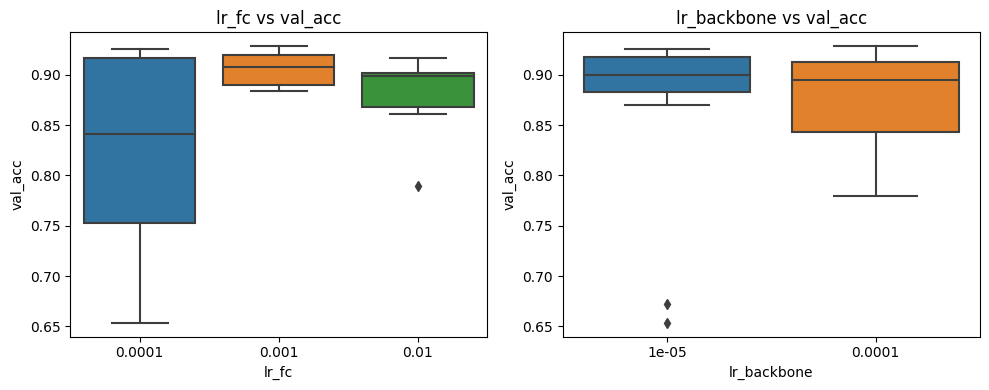

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.boxplot(x='lr_fc', y='val_acc', data=df_finetune)
plt.title("lr_fc vs val_acc")

plt.subplot(1,2,2)
sns.boxplot(x='lr_backbone', y='val_acc', data=df_finetune)
plt.title("lr_backbone vs val_acc")
plt.tight_layout()
plt.show()

l2正则化参数，最优值差别不大，整体上1e-5偏高。

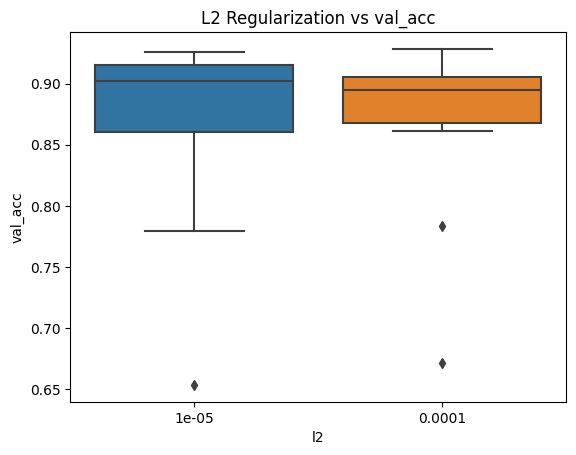

In [ ]:
sns.boxplot(x='l2', y='val_acc', data=df_finetune)
plt.title("L2 Regularization vs val_acc")
plt.show()

优化器选择，整体上AdamW偏高，观察表格结果前几名也是AdamW的组合比较多，但是AdamW似乎基本都是前期loss降低很快后期出现轻微过拟合。

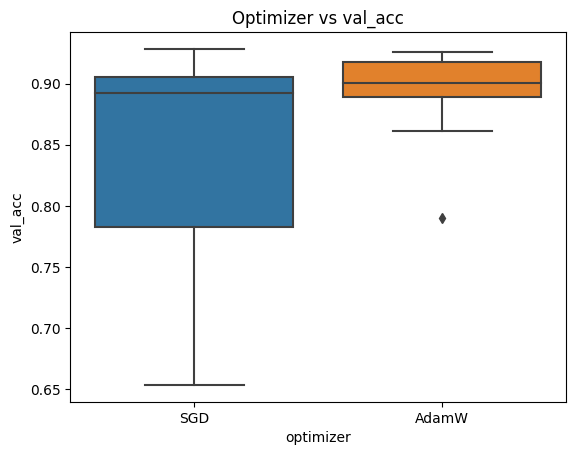

In [ ]:
sns.boxplot(x='optimizer', y='val_acc', data=df_finetune)
plt.title("Optimizer vs val_acc")
plt.show()

In [ ]:
# 保存完整记录
df_finetune_sorted = df_finetune.sort_values(by='val_acc', ascending=False)
df_finetune_sorted.to_csv('/kaggle/working/finetune_results.csv', index=False)


下面这个codeblock是修改了对train的数据增强方式，发现刚开始训练的时候val_acc显著高于train_acc的确是因为对train的数据增强过于复杂，但是为了得到更加robust的模型最终训练时仍然采用之前的数据增强方式（随机裁剪 + 翻转）。

In [19]:
import os
import copy
import itertools
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

# Step 1: 数据加载函数
def get_dataloaders(data_dir='caltech101_split_3way', batch_size=64, num_workers=4):
    data_transforms = {
        'train': transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
]),
        'val': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    }

    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
    dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=(x=='train'), num_workers=num_workers) for x in ['train', 'val']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
    class_names = image_datasets['train'].classes
    num_classes = len(class_names)

    return dataloaders, dataset_sizes, class_names, num_classes

# Step 2: 训练函数
def train_model(model, dataloaders, dataset_sizes, device, num_epochs, lr_fc, lr_backbone, l2,
                optimizer_type='SGD', log_name='run', fine_tune=True):

    writer = SummaryWriter(log_dir=f'runs/{log_name}')
    criterion = nn.CrossEntropyLoss()

    # 设置优化器
    if fine_tune:
        params = [
            {'params': model.fc.parameters(), 'lr': lr_fc},
            {'params': [p for n, p in model.named_parameters() if 'fc' not in n], 'lr': lr_backbone}
        ]
    else:
        params = model.parameters()

    if optimizer_type == 'SGD':
        optimizer = optim.SGD(params, lr=lr_fc, momentum=0.9, weight_decay=l2)
    elif optimizer_type == 'AdamW':
        optimizer = optim.AdamW(params, lr=lr_fc, weight_decay=l2)
    else:
        raise ValueError("Unsupported optimizer type")

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss = 0.0
            running_corrects = 0

            loop = tqdm(dataloaders[phase], desc=f'{phase.capitalize()} [{epoch+1}/{num_epochs}]')
            for inputs, labels in loop:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            writer.add_scalar(f'{phase}_loss', epoch_loss, epoch)
            writer.add_scalar(f'{phase}_acc', epoch_acc, epoch)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print(f'\nBest val Acc: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model

# Step 3: 网格搜索主程序
if __name__ == '__main__':
    data_dir = 'caltech101_split_3way'
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # 搜索空间
    lr_fc_list = [1e-2, 1e-3, 1e-4]
    lr_backbone_list = [1e-4, 1e-5]
    num_epochs_list = [10, 25]
    l2_list = [1e-4, 1e-5]
    batch_sizes = [16, 32]
    fine_tune_options = [True, False]
    optimizer_types = ['SGD', 'AdamW']

    trial = 0
    for batch_size, num_epochs, l2 in itertools.product(batch_sizes, num_epochs_list, l2_list):
        dataloaders, dataset_sizes, class_names, num_classes = get_dataloaders(data_dir, batch_size=batch_size)

        for fine_tune in fine_tune_options:
            lr_backbone_space = lr_backbone_list if fine_tune else [None]
            for lr_fc in lr_fc_list:
                for lr_backbone in lr_backbone_space:
                    for opt_type in (optimizer_types if fine_tune else ['SGD']):
                        trial += 1
                        log_name = f"trial_{trial}_bs{batch_size}_lrfc{lr_fc}_l2{l2}_ft{fine_tune}"
                        if fine_tune:
                            log_name += f"_lrbb{lr_backbone}_{opt_type}"
                        else:
                            log_name += "_scratch"

                        print(f"\n=== Running {log_name} ===")
                        # 初始化模型
                        if fine_tune:
                            model = models.resnet18(pretrained=True)
                        else:
                            model = models.resnet18(pretrained=False)

                        model.fc = nn.Linear(model.fc.in_features, num_classes)
                        model = model.to(device)

                        model = train_model(
                            model=model,
                            dataloaders=dataloaders,
                            dataset_sizes=dataset_sizes,
                            device=device,
                            num_epochs=num_epochs,
                            lr_fc=lr_fc,
                            lr_backbone=(lr_backbone if lr_backbone else lr_fc),
                            l2=l2,
                            optimizer_type=opt_type,
                            log_name=log_name,
                            fine_tune=fine_tune
                        )


=== Running trial_1_bs16_lrfc0.01_l20.0001_ftTrue_lrbb0.0001_SGD ===

Epoch 1/10


Train [1/10]: 100%|██████████| 377/377 [05:03<00:00,  1.24it/s]


train Loss: 1.2727 Acc: 0.7015


Val [1/10]: 100%|██████████| 79/79 [00:32<00:00,  2.41it/s]


val Loss: 0.3617 Acc: 0.8885

Epoch 2/10


Train [2/10]: 100%|██████████| 377/377 [05:49<00:00,  1.08it/s]


train Loss: 0.3291 Acc: 0.9082


Val [2/10]: 100%|██████████| 79/79 [00:31<00:00,  2.51it/s]


val Loss: 0.2852 Acc: 0.9172

Epoch 3/10


Train [3/10]:   2%|▏         | 9/377 [00:19<13:27,  2.19s/it]  


KeyboardInterrupt: 

得到的最佳参数如下：

In [14]:
best_params = {
    'lr_fc': 1e-3,
    'lr_backbone': 1e-5,
    'num_epochs': 25,
    'l2': 1e-5,
    'batch_size': 64,
    'optimizer': 'AdamW',  
}


In [ ]:
# 用搜索得到的 batch_size 重新设置 dataloaders
batch_size = best_params['batch_size']

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([  # 新增test数据的transform（同val）
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# 加载训练集、验证集和测试集
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=(x == 'train'), num_workers=4) for x in ['train', 'val', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
num_classes = len(class_names)


In [ ]:
def train_model(model, dataloaders, dataset_sizes, device,
                num_epochs, lr_fc, lr_backbone, weight_decay,
                log_name='run', fine_tune=True, optimizer_type='SGD'):

    writer = SummaryWriter(log_dir=f'runs/{log_name}')
    criterion = nn.CrossEntropyLoss()

    if fine_tune:
        params = [
            {'params': model.fc.parameters(), 'lr': lr_fc},
            {'params': [p for n, p in model.named_parameters() if 'fc' not in n], 'lr': lr_backbone}
        ]
    else:
        params = model.parameters()

    if optimizer_type == 'SGD':
        optimizer = optim.SGD(params, momentum=0.9, weight_decay=weight_decay)
    elif optimizer_type == 'AdamW':
        optimizer = optim.AdamW(params, weight_decay=weight_decay)
    else:
        raise ValueError(f'Unsupported optimizer: {optimizer_type}')

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss, running_corrects = 0.0, 0

            loop = tqdm(dataloaders[phase], desc=f'{phase.capitalize()} [{epoch+1}/{num_epochs}]')
            for inputs, labels in loop:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            writer.add_scalar(f'{phase}_loss', epoch_loss, epoch)
            writer.add_scalar(f'{phase}_acc', epoch_acc, epoch)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print(f'\nBest val Acc: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model


In [ ]:
# 评测函数
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, dataloader, class_names, device, title='Confusion Matrix'):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Evaluating'):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Accuracy
    acc = accuracy_score(all_labels, all_preds)
    print(f'\n Test Accuracy: {acc:.4f}')

    # Classification Report
    print("\nMore Classification Details:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()


仅使用 Caltech-101 数据集从随机初始化的网络参数开始训练：

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



Epoch 1/25


Train [1/25]: 100%|██████████| 95/95 [00:12<00:00,  7.43it/s]


train Loss: 3.7453 Acc: 0.2330


Val [1/25]: 100%|██████████| 20/20 [00:02<00:00,  8.06it/s]


val Loss: 3.4967 Acc: 0.2484

Epoch 2/25


Train [2/25]: 100%|██████████| 95/95 [00:12<00:00,  7.56it/s]


train Loss: 3.2960 Acc: 0.2833


Val [2/25]: 100%|██████████| 20/20 [00:02<00:00,  8.24it/s]


val Loss: 3.3440 Acc: 0.2580

Epoch 3/25


Train [3/25]: 100%|██████████| 95/95 [00:12<00:00,  7.53it/s]


train Loss: 3.0963 Acc: 0.3107


Val [3/25]: 100%|██████████| 20/20 [00:02<00:00,  8.13it/s]


val Loss: 3.0820 Acc: 0.3129

Epoch 4/25


Train [4/25]: 100%|██████████| 95/95 [00:12<00:00,  7.55it/s]


train Loss: 2.9253 Acc: 0.3400


Val [4/25]: 100%|██████████| 20/20 [00:02<00:00,  8.09it/s]


val Loss: 2.9896 Acc: 0.3225

Epoch 5/25


Train [5/25]: 100%|██████████| 95/95 [00:12<00:00,  7.51it/s]


train Loss: 2.7724 Acc: 0.3657


Val [5/25]: 100%|██████████| 20/20 [00:02<00:00,  6.69it/s]


val Loss: 2.8460 Acc: 0.3543

Epoch 6/25


Train [6/25]: 100%|██████████| 95/95 [00:12<00:00,  7.56it/s]


train Loss: 2.6559 Acc: 0.3805


Val [6/25]: 100%|██████████| 20/20 [00:02<00:00,  8.32it/s]


val Loss: 2.5570 Acc: 0.4116

Epoch 7/25


Train [7/25]: 100%|██████████| 95/95 [00:12<00:00,  7.54it/s]


train Loss: 2.5255 Acc: 0.4071


Val [7/25]: 100%|██████████| 20/20 [00:02<00:00,  7.62it/s]


val Loss: 2.3957 Acc: 0.4459

Epoch 8/25


Train [8/25]: 100%|██████████| 95/95 [00:12<00:00,  7.50it/s]


train Loss: 2.4018 Acc: 0.4238


Val [8/25]: 100%|██████████| 20/20 [00:02<00:00,  8.11it/s]


val Loss: 2.3486 Acc: 0.4387

Epoch 9/25


Train [9/25]: 100%|██████████| 95/95 [00:12<00:00,  7.53it/s]


train Loss: 2.3056 Acc: 0.4406


Val [9/25]: 100%|██████████| 20/20 [00:02<00:00,  7.98it/s]


val Loss: 2.1458 Acc: 0.4912

Epoch 10/25


Train [10/25]: 100%|██████████| 95/95 [00:12<00:00,  7.43it/s]


train Loss: 2.2076 Acc: 0.4539


Val [10/25]: 100%|██████████| 20/20 [00:02<00:00,  8.17it/s]


val Loss: 2.6462 Acc: 0.3559

Epoch 11/25


Train [11/25]: 100%|██████████| 95/95 [00:12<00:00,  7.56it/s]


train Loss: 2.1252 Acc: 0.4713


Val [11/25]: 100%|██████████| 20/20 [00:02<00:00,  8.05it/s]


val Loss: 2.0658 Acc: 0.4729

Epoch 12/25


Train [12/25]: 100%|██████████| 95/95 [00:12<00:00,  7.49it/s]


train Loss: 2.0364 Acc: 0.4960


Val [12/25]: 100%|██████████| 20/20 [00:02<00:00,  8.06it/s]


val Loss: 1.9608 Acc: 0.5183

Epoch 13/25


Train [13/25]: 100%|██████████| 95/95 [00:12<00:00,  7.53it/s]


train Loss: 1.9461 Acc: 0.5194


Val [13/25]: 100%|██████████| 20/20 [00:02<00:00,  7.99it/s]


val Loss: 1.9050 Acc: 0.5255

Epoch 14/25


Train [14/25]: 100%|██████████| 95/95 [00:12<00:00,  7.47it/s]


train Loss: 1.8622 Acc: 0.5325


Val [14/25]: 100%|██████████| 20/20 [00:02<00:00,  8.17it/s]


val Loss: 1.8526 Acc: 0.5430

Epoch 15/25


Train [15/25]: 100%|██████████| 95/95 [00:12<00:00,  7.55it/s]


train Loss: 1.7995 Acc: 0.5455


Val [15/25]: 100%|██████████| 20/20 [00:02<00:00,  8.23it/s]


val Loss: 1.8499 Acc: 0.5350

Epoch 16/25


Train [16/25]: 100%|██████████| 95/95 [00:12<00:00,  7.49it/s]


train Loss: 1.7251 Acc: 0.5622


Val [16/25]: 100%|██████████| 20/20 [00:02<00:00,  7.94it/s]


val Loss: 1.8905 Acc: 0.5342

Epoch 17/25


Train [17/25]: 100%|██████████| 95/95 [00:12<00:00,  7.52it/s]


train Loss: 1.6393 Acc: 0.5772


Val [17/25]: 100%|██████████| 20/20 [00:02<00:00,  8.16it/s]


val Loss: 1.7179 Acc: 0.5740

Epoch 18/25


Train [18/25]: 100%|██████████| 95/95 [00:12<00:00,  7.50it/s]


train Loss: 1.5936 Acc: 0.5883


Val [18/25]: 100%|██████████| 20/20 [00:02<00:00,  8.27it/s]


val Loss: 1.6450 Acc: 0.5987

Epoch 19/25


Train [19/25]: 100%|██████████| 95/95 [00:12<00:00,  7.57it/s]


train Loss: 1.5392 Acc: 0.5949


Val [19/25]: 100%|██████████| 20/20 [00:02<00:00,  8.26it/s]


val Loss: 1.6627 Acc: 0.5693

Epoch 20/25


Train [20/25]: 100%|██████████| 95/95 [00:12<00:00,  7.52it/s]


train Loss: 1.5072 Acc: 0.6085


Val [20/25]: 100%|██████████| 20/20 [00:02<00:00,  7.74it/s]


val Loss: 1.5907 Acc: 0.6131

Epoch 21/25


Train [21/25]: 100%|██████████| 95/95 [00:12<00:00,  7.52it/s]


train Loss: 1.4334 Acc: 0.6301


Val [21/25]: 100%|██████████| 20/20 [00:02<00:00,  7.99it/s]


val Loss: 1.3679 Acc: 0.6529

Epoch 22/25


Train [22/25]: 100%|██████████| 95/95 [00:12<00:00,  7.54it/s]


train Loss: 1.3779 Acc: 0.6399


Val [22/25]: 100%|██████████| 20/20 [00:02<00:00,  6.80it/s]


val Loss: 1.4215 Acc: 0.6425

Epoch 23/25


Train [23/25]: 100%|██████████| 95/95 [00:12<00:00,  7.56it/s]


train Loss: 1.3389 Acc: 0.6444


Val [23/25]: 100%|██████████| 20/20 [00:02<00:00,  8.13it/s]


val Loss: 1.3813 Acc: 0.6433

Epoch 24/25


Train [24/25]: 100%|██████████| 95/95 [00:12<00:00,  7.54it/s]


train Loss: 1.3033 Acc: 0.6513


Val [24/25]: 100%|██████████| 20/20 [00:02<00:00,  7.78it/s]


val Loss: 1.5893 Acc: 0.6027

Epoch 25/25


Train [25/25]: 100%|██████████| 95/95 [00:12<00:00,  7.45it/s]


train Loss: 1.3051 Acc: 0.6586


Val [25/25]: 100%|██████████| 20/20 [00:02<00:00,  7.99it/s]


val Loss: 1.3728 Acc: 0.6401

Best val Acc: 0.6529


Evaluating: 100%|██████████| 22/22 [00:02<00:00,  8.14it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Test Accuracy: 0.6244

More Classification Details:
                 precision    recall  f1-score   support

          Faces       0.78      0.65      0.71        66
     Faces_easy       0.67      0.92      0.78        66
       Leopards       0.88      0.93      0.90        30
     Motorbikes       0.92      0.98      0.95       121
      accordion       0.75      0.67      0.71         9
      airplanes       0.85      0.98      0.91       120
         anchor       0.00      0.00      0.00         7
            ant       0.25      0.29      0.27         7
         barrel       0.00      0.00      0.00         8
           bass       0.15      0.22      0.18         9
         beaver       0.25      0.12      0.17         8
      binocular       0.25      0.50      0.33         6
         bonsai       0.65      0.85      0.74        20
          brain       0.35      0.69      0.47        16
   brontosaurus       0.00      0.00      0.00         7
         buddha       0.56      0

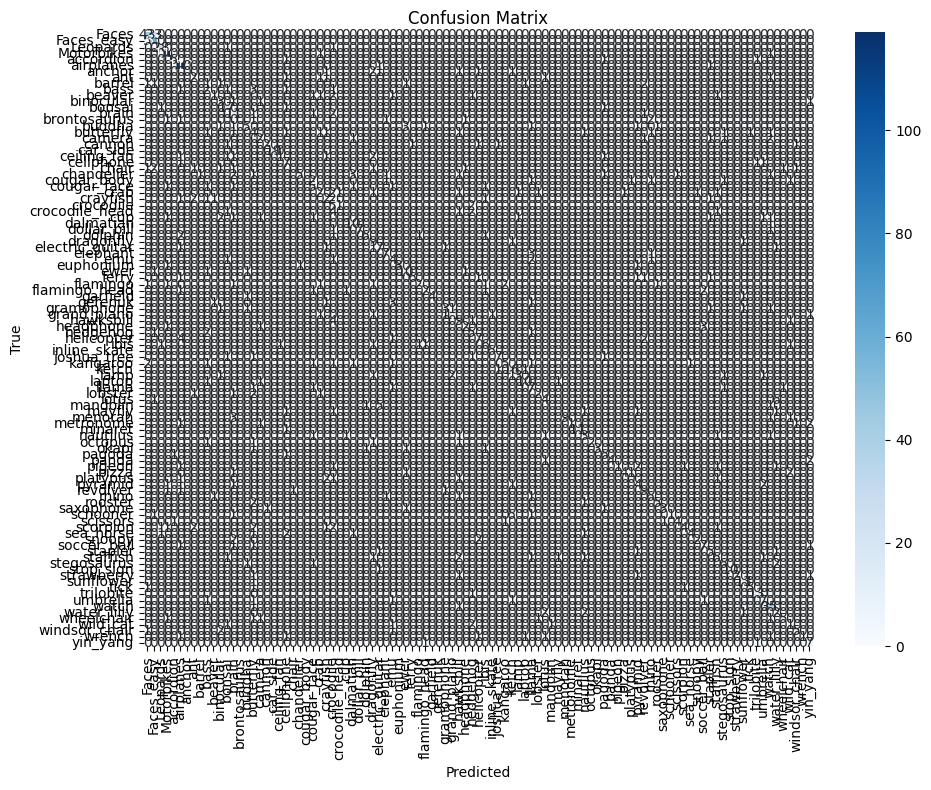

In [20]:
model_scratch = models.resnet18(pretrained=False)
model_scratch.fc = nn.Linear(model_scratch.fc.in_features, num_classes)
model_scratch = model_scratch.to(device)

model_scratch = train_model(model_scratch, dataloaders, dataset_sizes, device,
                            num_epochs=best_params['num_epochs'],
                            lr_fc=best_params['lr_fc'],
                            lr_backbone=best_params['lr_fc'],  #none
                            weight_decay=best_params['l2'],
                            log_name='scratch_final',
                            fine_tune=False,
                            optimizer_type=best_params['optimizer'])
evaluate_model(model_scratch, dataloaders['test'], class_names, device)

在ImageNet上预训练得到的网络参数进行初始化并微调过的模型：


Epoch 1/25


Train [1/25]: 100%|██████████| 95/95 [00:12<00:00,  7.54it/s]


train Loss: 2.6107 Acc: 0.4665


Val [1/25]: 100%|██████████| 20/20 [00:02<00:00,  8.10it/s]


val Loss: 1.1303 Acc: 0.7540

Epoch 2/25


Train [2/25]: 100%|██████████| 95/95 [00:12<00:00,  7.50it/s]


train Loss: 1.0958 Acc: 0.7632


Val [2/25]: 100%|██████████| 20/20 [00:02<00:00,  8.29it/s]


val Loss: 0.5534 Acc: 0.8694

Epoch 3/25


Train [3/25]: 100%|██████████| 95/95 [00:12<00:00,  7.54it/s]


train Loss: 0.7444 Acc: 0.8253


Val [3/25]: 100%|██████████| 20/20 [00:02<00:00,  8.33it/s]


val Loss: 0.4226 Acc: 0.8909

Epoch 4/25


Train [4/25]: 100%|██████████| 95/95 [00:12<00:00,  7.51it/s]


train Loss: 0.5807 Acc: 0.8576


Val [4/25]: 100%|██████████| 20/20 [00:02<00:00,  8.28it/s]


val Loss: 0.3423 Acc: 0.9164

Epoch 5/25


Train [5/25]: 100%|██████████| 95/95 [00:12<00:00,  7.54it/s]


train Loss: 0.5010 Acc: 0.8722


Val [5/25]: 100%|██████████| 20/20 [00:02<00:00,  8.13it/s]


val Loss: 0.3019 Acc: 0.9236

Epoch 6/25


Train [6/25]: 100%|██████████| 95/95 [00:12<00:00,  7.42it/s]


train Loss: 0.4506 Acc: 0.8813


Val [6/25]: 100%|██████████| 20/20 [00:02<00:00,  8.18it/s]


val Loss: 0.2987 Acc: 0.9076

Epoch 7/25


Train [7/25]: 100%|██████████| 95/95 [00:12<00:00,  7.48it/s]


train Loss: 0.3949 Acc: 0.8968


Val [7/25]: 100%|██████████| 20/20 [00:02<00:00,  8.14it/s]


val Loss: 0.2612 Acc: 0.9196

Epoch 8/25


Train [8/25]: 100%|██████████| 95/95 [00:12<00:00,  7.52it/s]


train Loss: 0.3848 Acc: 0.8976


Val [8/25]: 100%|██████████| 20/20 [00:02<00:00,  8.10it/s]


val Loss: 0.2583 Acc: 0.9204

Epoch 9/25


Train [9/25]: 100%|██████████| 95/95 [00:12<00:00,  7.53it/s]


train Loss: 0.3497 Acc: 0.9041


Val [9/25]: 100%|██████████| 20/20 [00:02<00:00,  8.03it/s]


val Loss: 0.2495 Acc: 0.9172

Epoch 10/25


Train [10/25]: 100%|██████████| 95/95 [00:12<00:00,  7.55it/s]


train Loss: 0.3311 Acc: 0.9097


Val [10/25]: 100%|██████████| 20/20 [00:02<00:00,  6.98it/s]


val Loss: 0.2427 Acc: 0.9299

Epoch 11/25


Train [11/25]: 100%|██████████| 95/95 [00:12<00:00,  7.54it/s]


train Loss: 0.3096 Acc: 0.9154


Val [11/25]: 100%|██████████| 20/20 [00:02<00:00,  8.29it/s]


val Loss: 0.2510 Acc: 0.9188

Epoch 12/25


Train [12/25]: 100%|██████████| 95/95 [00:12<00:00,  7.57it/s]


train Loss: 0.3245 Acc: 0.9096


Val [12/25]: 100%|██████████| 20/20 [00:02<00:00,  8.22it/s]


val Loss: 0.2263 Acc: 0.9331

Epoch 13/25


Train [13/25]: 100%|██████████| 95/95 [00:12<00:00,  7.40it/s]


train Loss: 0.2993 Acc: 0.9160


Val [13/25]: 100%|██████████| 20/20 [00:02<00:00,  7.97it/s]


val Loss: 0.2375 Acc: 0.9307

Epoch 14/25


Train [14/25]: 100%|██████████| 95/95 [00:12<00:00,  7.55it/s]


train Loss: 0.2761 Acc: 0.9247


Val [14/25]: 100%|██████████| 20/20 [00:02<00:00,  8.31it/s]


val Loss: 0.2247 Acc: 0.9355

Epoch 15/25


Train [15/25]: 100%|██████████| 95/95 [00:12<00:00,  7.49it/s]


train Loss: 0.2700 Acc: 0.9245


Val [15/25]: 100%|██████████| 20/20 [00:02<00:00,  8.19it/s]


val Loss: 0.2233 Acc: 0.9283

Epoch 16/25


Train [16/25]: 100%|██████████| 95/95 [00:12<00:00,  7.57it/s]


train Loss: 0.2697 Acc: 0.9213


Val [16/25]: 100%|██████████| 20/20 [00:02<00:00,  8.40it/s]


val Loss: 0.2211 Acc: 0.9355

Epoch 17/25


Train [17/25]: 100%|██████████| 95/95 [00:12<00:00,  7.46it/s]


train Loss: 0.2662 Acc: 0.9275


Val [17/25]: 100%|██████████| 20/20 [00:02<00:00,  8.26it/s]


val Loss: 0.2217 Acc: 0.9331

Epoch 18/25


Train [18/25]: 100%|██████████| 95/95 [00:12<00:00,  7.54it/s]


train Loss: 0.2396 Acc: 0.9330


Val [18/25]: 100%|██████████| 20/20 [00:02<00:00,  8.15it/s]


val Loss: 0.2289 Acc: 0.9260

Epoch 19/25


Train [19/25]: 100%|██████████| 95/95 [00:12<00:00,  7.49it/s]


train Loss: 0.2493 Acc: 0.9293


Val [19/25]: 100%|██████████| 20/20 [00:02<00:00,  8.14it/s]


val Loss: 0.2308 Acc: 0.9236

Epoch 20/25


Train [20/25]: 100%|██████████| 95/95 [00:12<00:00,  7.54it/s]


train Loss: 0.2439 Acc: 0.9281


Val [20/25]: 100%|██████████| 20/20 [00:02<00:00,  8.41it/s]


val Loss: 0.2363 Acc: 0.9252

Epoch 21/25


Train [21/25]: 100%|██████████| 95/95 [00:12<00:00,  7.45it/s]


train Loss: 0.2249 Acc: 0.9358


Val [21/25]: 100%|██████████| 20/20 [00:02<00:00,  8.08it/s]


val Loss: 0.2221 Acc: 0.9299

Epoch 22/25


Train [22/25]: 100%|██████████| 95/95 [00:12<00:00,  7.52it/s]


train Loss: 0.2241 Acc: 0.9331


Val [22/25]: 100%|██████████| 20/20 [00:02<00:00,  8.30it/s]


val Loss: 0.2360 Acc: 0.9252

Epoch 23/25


Train [23/25]: 100%|██████████| 95/95 [00:12<00:00,  7.56it/s]


train Loss: 0.2261 Acc: 0.9346


Val [23/25]: 100%|██████████| 20/20 [00:02<00:00,  8.40it/s]


val Loss: 0.2368 Acc: 0.9268

Epoch 24/25


Train [24/25]: 100%|██████████| 95/95 [00:12<00:00,  7.56it/s]


train Loss: 0.2299 Acc: 0.9336


Val [24/25]: 100%|██████████| 20/20 [00:02<00:00,  8.43it/s]


val Loss: 0.2170 Acc: 0.9347

Epoch 25/25


Train [25/25]: 100%|██████████| 95/95 [00:12<00:00,  7.52it/s]


train Loss: 0.2064 Acc: 0.9413


Val [25/25]: 100%|██████████| 20/20 [00:02<00:00,  6.90it/s]


val Loss: 0.2138 Acc: 0.9363

Best val Acc: 0.9363


Evaluating: 100%|██████████| 22/22 [00:03<00:00,  5.87it/s]



 Test Accuracy: 0.9276

More Classification Details:
                 precision    recall  f1-score   support

          Faces       0.89      0.85      0.87        66
     Faces_easy       0.86      0.91      0.88        66
       Leopards       1.00      1.00      1.00        30
     Motorbikes       1.00      0.99      1.00       121
      accordion       1.00      1.00      1.00         9
      airplanes       0.98      1.00      0.99       120
         anchor       1.00      0.71      0.83         7
            ant       1.00      0.86      0.92         7
         barrel       1.00      0.62      0.77         8
           bass       1.00      0.67      0.80         9
         beaver       1.00      0.88      0.93         8
      binocular       1.00      0.67      0.80         6
         bonsai       1.00      0.95      0.97        20
          brain       0.94      1.00      0.97        16
   brontosaurus       0.86      0.86      0.86         7
         buddha       1.00      1

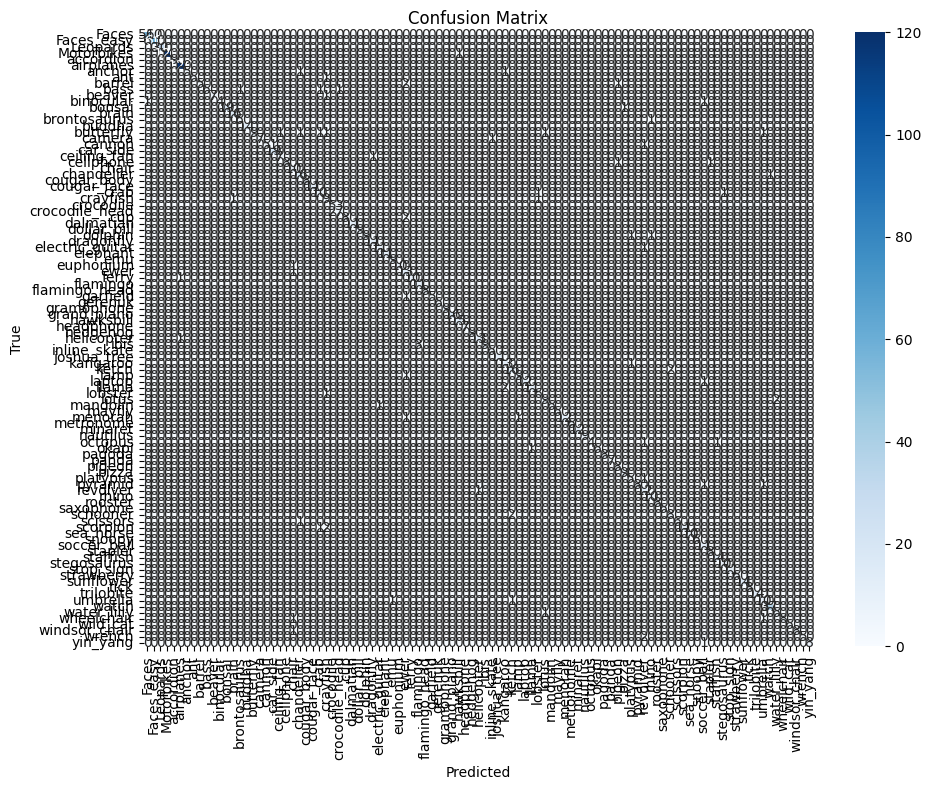

In [19]:
model_finetune = models.resnet18(pretrained=True)
model_finetune.fc = nn.Linear(model_finetune.fc.in_features, num_classes)
model_finetune = model_finetune.to(device)

model_finetune = train_model(model_finetune, dataloaders, dataset_sizes, device,
                             num_epochs=best_params['num_epochs'],
                             lr_fc=best_params['lr_fc'],
                             lr_backbone=best_params['lr_backbone'],
                             weight_decay=best_params['l2'],
                             log_name='finetune_final',
                             fine_tune=True,
                             optimizer_type=best_params['optimizer'])
evaluate_model(model_finetune, dataloaders['test'], class_names, device)

In [6]:
%load_ext tensorboard
%tensorboard --logdir /kaggle/input/logs-for-plots/kaggle/working/runs/finetune_final

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6008 (pid 138), started 0:01:58 ago. (Use '!kill 138' to kill it.)

<IPython.core.display.Javascript object>

In [24]:
!zip -r /kaggle/working/runs.zip /kaggle/working/runs


  adding: kaggle/working/runs/ (stored 0%)
  adding: kaggle/working/runs/final_trial_2_bs64_lrfc0.001_l21e-05_ftTrue_lrbb1e-05_AdamW/ (stored 0%)
  adding: kaggle/working/runs/final_trial_2_bs64_lrfc0.001_l21e-05_ftTrue_lrbb1e-05_AdamW/events.out.tfevents.1746770979.28b466cafb48.31.2 (deflated 62%)
  adding: kaggle/working/runs/finetune_final/ (stored 0%)
  adding: kaggle/working/runs/finetune_final/events.out.tfevents.1746771415.28b466cafb48.31.3 (deflated 20%)
  adding: kaggle/working/runs/finetune_final/events.out.tfevents.1746771578.28b466cafb48.31.4 (deflated 62%)
  adding: kaggle/working/runs/scratch_final/ (stored 0%)
  adding: kaggle/working/runs/scratch_final/events.out.tfevents.1746772008.28b466cafb48.31.5 (deflated 62%)
  adding: kaggle/working/runs/final_trial_1_bs64_lrfc0.001_l20.0001_ftTrue_lrbb0.0001_SGD/ (stored 0%)
  adding: kaggle/working/runs/final_trial_1_bs64_lrfc0.001_l20.0001_ftTrue_lrbb0.0001_SGD/events.out.tfevents.1746770512.28b466cafb48.31.0 (deflated 46%)
  